In [1]:
#!pip install matplotlib
#!pip install pandas
#!pip install statsmodels
#!pip install scipy
#!pip install numpy

# Notebook Projet RI

## Librairies

In [2]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
from scipy.optimize import curve_fit
from scipy.signal import welch
from scipy.optimize import curve_fit

In [3]:
# bout de code pour reload automatiquement la librairie avec les fonctions à chaque exécution de la cellule
import lib
importlib.reload(lib)
from lib import *

## Préparation des données

In [4]:
# Préparation du dataframe météo
df_gx = pd.read_csv(
    "../Data/Meteo_GX/vw2d-prcp-vpd-T55-30_2016-2024.csv",
    sep=";",
    decimal=".",
    parse_dates=["#TIMESTAMP"],
    dayfirst=True,
)
df_gx = df_gx.set_index("#TIMESTAMP")

# moyennes journalières
df_gx_daily = pd.DataFrame({
    "pluie": df_gx["Pluie"].resample("D").sum(),
    "amplitude_j_vpd": df_gx["vpd (55m)"].resample("D").agg(lambda x: x.max() - x.min()),
    "temp55": df_gx["Temp(55)"].resample("D").mean(),
    "temp30": df_gx["Temp(30)"].resample("D").mean(),
    "vent": df_gx["Vit vent"].resample("D").mean()
})

pluie_12j = df_gx_daily["pluie"].rolling("12D", closed="right").sum()             # pour comparaison avec les données SAR

mask = (
    (df_gx_daily.index < "2021-01-01") |
    ((df_gx_daily.index >= "2023-01-01") & (df_gx_daily.index < "2024-01-01"))
)

df_gx_daily.loc[mask, "amplitude_j_vpd"] *= 8.78

df_gx_daily.describe()

pluie  amplitude_j_vpd       temp55       temp30         vent
count  3288.000000      3241.000000  3245.000000  2980.000000  3261.000000
mean      8.700608         9.155559    26.132560    26.086330     2.734380
std      15.827785         3.686165     0.964680     1.008163     0.710540
min       0.000000         0.000000    23.039583    22.708333     0.002000
25%       0.000000         6.497200    25.500000    25.429167     2.212500
50%       1.800000         8.860000    26.191667    26.170833     2.731250
75%      10.000000        11.765200    26.795833    26.791875     3.238604
max     148.800000        32.410000    28.999286    29.342143     4.733333

In [5]:
def prepa_files(path,tolerance=100):
    df = pd.read_csv(path)
    df = df.replace(-np.inf, np.nan).dropna()
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time').sort_index()
    mean = df['value'].mean()
    std = df['value'].std()
    low, high = mean - tolerance*std, mean + tolerance*std
    df_clean = df[(df['value'] >= low) & (df['value'] <= high)]
    return df_clean

def prepa_files2(path, tolerance=100):
    df = pd.read_csv(path)
    df = df.replace(-np.inf, np.nan).dropna()
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time').sort_index()
    mean1 = df['value1'].mean()
    mean2 = df['value2'].mean()
    std1 = df['value1'].std()
    std2 = df['value2'].std()

    low1, high1 = mean1 - tolerance*std1, mean1 + tolerance*std1
    low2, high2 = mean2 - tolerance*std2, mean2 + tolerance*std2

    df_clean1 = df[(df['value1'] >= low1) & (df['value1'] <= high1)]
    df_clean1.rename(columns={"value1": "value"}, inplace=True)
    df_clean2 = df[(df['value2'] >= low2) & (df['value2'] <= high2)]
    df_clean2.rename(columns={"value2": "value"}, inplace=True)

    return df_clean1, df_clean2

def prepa_files3(path, tolerance=5,name_col1="moy_masked",name_col2="moy_unmasked"):
    df = pd.read_csv(path)
    df = df.replace(-np.inf, np.nan).dropna()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').sort_index()
    mean1 = df[name_col1].mean()
    mean2 = df[name_col2].mean()
    std1 = df[name_col1].std()
    std2 = df[name_col2].std()

    low1, high1 = mean1 - tolerance*std1, mean1 + tolerance*std1
    low2, high2 = mean2 - tolerance*std2, mean2 + tolerance*std2

    df_clean1 = df[(df[name_col1] >= low1) & (df[name_col1] <= high1)]
    df_clean1.rename(columns={name_col1: "value"}, inplace=True)
    df_clean2 = df[(df[name_col2] >= low2) & (df[name_col2] <= high2)]
    df_clean2.rename(columns={name_col2: "value"}, inplace=True)

    return df_clean1, df_clean2

In [6]:
# Préparation des dataframes des séries temporelles
Data_file = "../Data/S1A_ASC-DSC_VV-VH"

df_VH_ASC_TropiScat = prepa_files(f"{Data_file}/s1a_vh_ASC_047_TropiScat.csv")
df_VH_DSC_TropiScat = prepa_files(f"{Data_file}/s1a_vh_DSC_039_TropiScat.csv")
df_VV_ASC_TropiScat = prepa_files(f"{Data_file}/s1a_vv_ASC_047_TropiScat.csv")
df_VV_DSC_TropiScat = prepa_files(f"{Data_file}/s1a_vv_DSC_039_TropiScat.csv")

dfs_TropiScat = {
    "VV_ASC": df_VV_ASC_TropiScat,
    "VH_ASC": df_VH_ASC_TropiScat,
    "VV_DSC": df_VV_DSC_TropiScat,
    "VH_DSC": df_VH_DSC_TropiScat,
}


# affichage des séries temporelles VH_ASC et VH_DSC (TropiScat) avec STL
stl1,res1 = ST(df_VH_ASC_TropiScat,period=30)
stl2,res2 = ST(df_VH_DSC_TropiScat,period=30)
# affichage(df_VH_ASC_TropiScat,stl1,res1,df_VH_DSC_TropiScat,stl2,res2)

df_VH_ASC_allROI = prepa_files(f"{Data_file}/s1a_vh_ASC_047_allROI.csv")
df_VH_DSC_allROI = prepa_files(f"{Data_file}/s1a_vh_DSC_039_allROI.csv")
df_VV_ASC_allROI = prepa_files(f"{Data_file}/s1a_vv_ASC_047_allROI.csv")
df_VV_DSC_allROI = prepa_files(f"{Data_file}/s1a_vv_DSC_039_allROI.csv")

dfs_allROI = {
    "VV_ASC": df_VV_ASC_allROI,
    "VH_ASC": df_VH_ASC_allROI,
    "VV_DSC": df_VV_DSC_allROI,
    "VH_DSC": df_VH_DSC_allROI,
}

#stl3,res3 = ST(df_clean_all,period=30)
#stl4,res4 = ST(df_clean_DSC_all,period=30)
#affichage(df_clean_all,stl3,res3,df_clean_DSC_all,stl4,res4)

Data_file2 = "../Data/ALOS"
df_ALOS_HV_allROI,df_ALOS_HH_allROI = prepa_files2(f"{Data_file2}/ts_WBD-DSC_HV-HH_All.csv")
df_ALOS_HV_TropiScat,df_ALOS_HH_TropiScat = prepa_files2(f"{Data_file2}/ts_WBD-DSC_HV-HH_TropiScat.csv")

Data_file3 = "../Data/StudyCase_S1"
df_defol_VV_allROI,df_intact_VV_allROI = prepa_files3(f"{Data_file3}/ts_s1a_21NZF_vv_ASC_120_867km2.csv")
df_defol_VV_ROI,df_std_defol_VV_ROI = prepa_files3(f"{Data_file3}/ts_s1a_21NZF_vv_ASC_120_1ha-defoliated.csv",name_col1="moy_masked",name_col2="std_masked")
df_defol_VH_allROI,df_intact_VH_allROI = prepa_files3(f"{Data_file3}/ts_s1a_21NZF_vh_ASC_120_867km2.csv")

print(df_defol_VV_ROI.head())

               value  std_masked
date                            
2017-01-06 -6.813543   -9.358650
2017-01-18 -5.984933  -10.365745
2017-01-30 -6.650569  -11.540289
2017-02-11 -6.144981  -10.549965
2017-02-23 -5.440421   -9.945670


C:\Users\thoma\AppData\Local\Temp\ipykernel_8012\3123163755.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean1.rename(columns={name_col1: "value"}, inplace=True)


In [7]:
df_gx_daily = df_gx_daily.loc[df_VV_ASC_allROI.index.min(): df_VV_ASC_allROI.index.max()] 

df_gx_daily.describe()

pluie  amplitude_j_vpd       temp55       temp30         vent
count  2922.000000      2889.000000  2893.000000  2711.000000  2895.000000
mean      8.744730         9.196729    26.153396    26.060326     2.727926
std      15.679994         3.694128     0.983028     1.025612     0.712614
min       0.000000         0.000000    23.039583    22.708333     0.002000
25%       0.000000         6.530000    25.497917    25.386458     2.204167
50%       1.900000         8.867800    26.202083    26.116875     2.725000
75%      10.200000        11.765200    26.854167    26.760729     3.232917
max     147.000000        32.410000    28.999286    29.342143     4.733333

In [8]:
# Série pluie journalière
pluie = df_gx_daily["pluie"]

def correlation_pleine_serie(signal,pluie):
    pluie_12j = []
    for date in signal.index:
        # Fenêtre 12 jours avant l'acquisition (exclu)
        start = date - pd.Timedelta(days=12)
        end = date

        pluie_12j.append(pluie.loc[start:end].sum())

    pluie_12j_on_sar = pd.Series(pluie_12j, index=signal.index)
    common = pd.concat([signal, pluie_12j_on_sar], axis=1).dropna()
    signal_clean = common.iloc[:, 0]
    pluie12_clean = common.iloc[:, 1]
    corr = signal_clean.corr(pluie12_clean)
    return corr

for name, df in dfs_TropiScat.items():
    corr = correlation_pleine_serie(df["value"], pluie)
    print(f"Corrélation TropiScat {name} vs pluie 12j = {corr}")


for name, df in dfs_allROI.items():
    corr = correlation_pleine_serie(df["value"], pluie)
    print(f"Corrélation allROI {name} vs pluie 12j = {corr}")

Corrélation TropiScat VV_ASC vs pluie 12j = 0.2734005324440307
Corrélation TropiScat VH_ASC vs pluie 12j = 0.1052690731639412
Corrélation TropiScat VV_DSC vs pluie 12j = 0.2182462910761819
Corrélation TropiScat VH_DSC vs pluie 12j = 0.16731418665474826
Corrélation allROI VV_ASC vs pluie 12j = 0.4824358276111926
Corrélation allROI VH_ASC vs pluie 12j = 0.32957665633907784
Corrélation allROI VV_DSC vs pluie 12j = 0.4423550648420274
Corrélation allROI VH_DSC vs pluie 12j = 0.3229666156134657


In [9]:
# bout de code pour reload automatiquement la librairie avec les fonctions à chaque exécution de la cellule
import lib
importlib.reload(lib)
from lib import *

## DSP avec Welch

Calcul de la psd (méthode de welch). On détecte les pics grâce à la fonction \textit{find_peaks} de scipy.


===== Overlap Analysis = 70% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.986), np.float64(0.493)] years or, [360. 180.]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.822), np.float64(0.493)] years or, [300. 180.]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.997), np.float64(0.499)] years or, [364. 182.]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.871), np.float64(0.436)] years or, [318. 159.]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.995), np.float64(0.442)] years or, [363.         161.33333333]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_70pct_VH_DSC_allROI.png


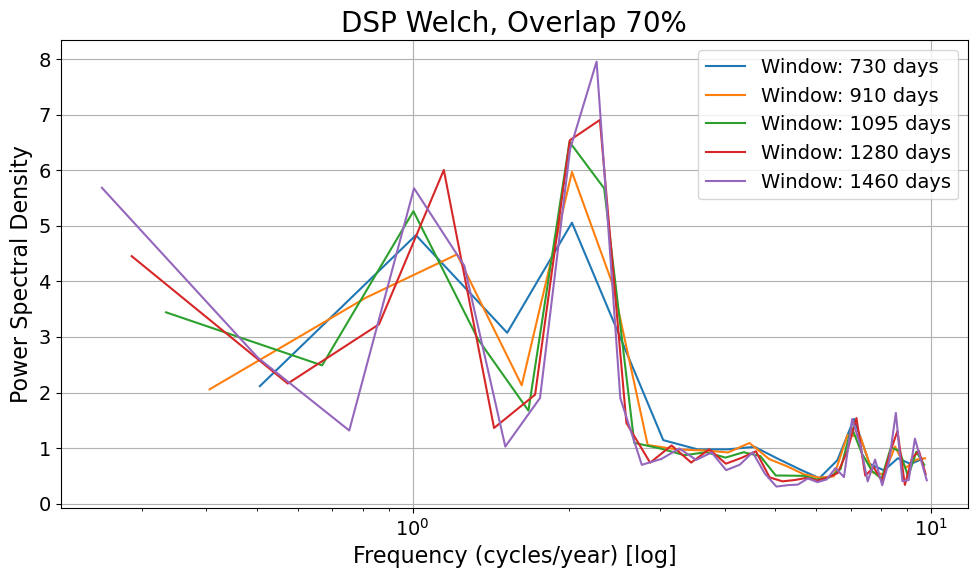


===== Overlap Analysis = 80% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.986), np.float64(0.493)] years or, [360. 180.]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.822), np.float64(0.493)] years or, [300. 180.]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.997), np.float64(0.499)] years or, [364. 182.]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.871), np.float64(0.436)] years or, [318. 159.]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.995), np.float64(0.442)] years or, [363.         161.33333333]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_80pct_VH_DSC_allROI.png


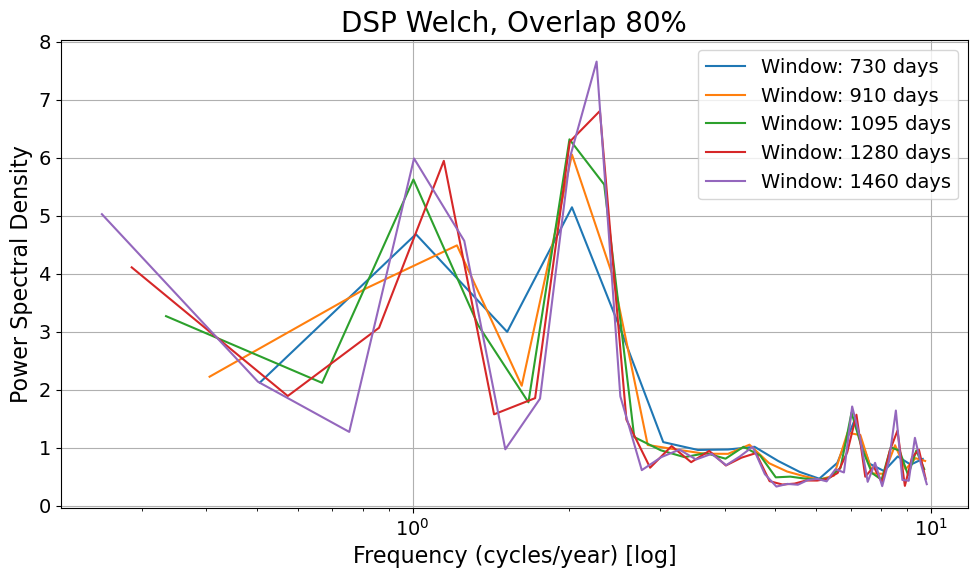


===== Overlap Analysis = 90% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.986), np.float64(0.493)] years or, [360. 180.]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.822), np.float64(0.493)] years or, [300. 180.]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.997), np.float64(0.499)] years or, [364. 182.]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.871), np.float64(0.436)] years or, [318. 159.]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.995), np.float64(0.442)] years or, [363.         161.33333333]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_90pct_VH_DSC_allROI.png


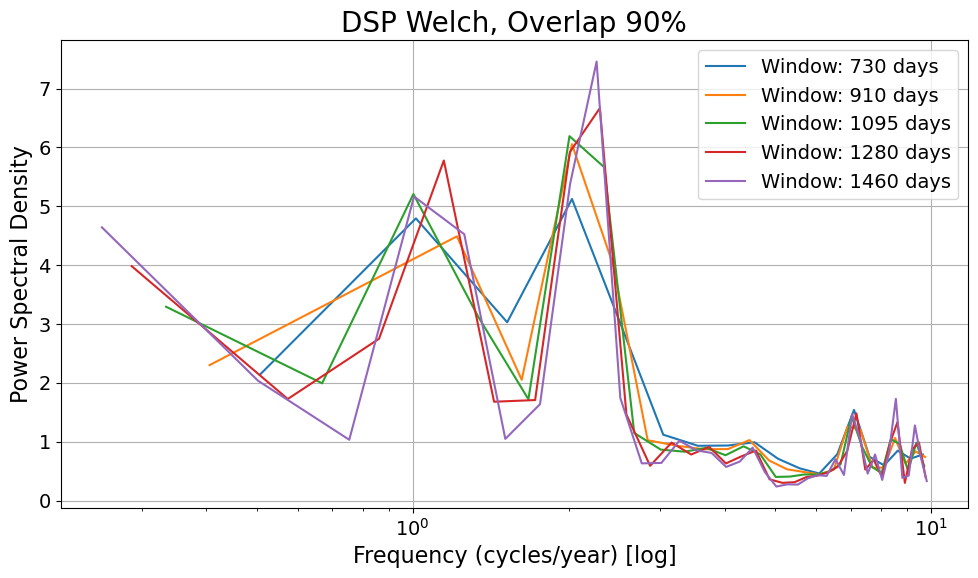

In [10]:
psd_welch_annee(df_VH_DSC_allROI, "VH_DSC_allROI", window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90], n_peaks=2, outdir="figures_welch", prefix="PSD", show=True)

Ici on retrouve 2 pics, en moyenne 1 pic à ~360 jours (1 an) et un autre à ~180 jours (6 mois). Les pics détectés dépendent du signal choisi pour la DSP.

## Fit de fonctions avec curve_fit

fonction ajustée:
$$y_1(t) = a+bt+A_1sin(t \omega_1)+B_1cos(t \omega_1)+A_2sin(t \omega_2)+B_2cos(t \omega_2)$$

Avec $\omega_1 = \dfrac{2 \pi}{T_1}$ , $ \omega_2 = \dfrac{2 \pi}{T_2}$ où $T_1$ et $T_2$ sont les 2 périodes dominantes trouvées ci-dessus ([360,180]).

Et $a,b,A_1,B_1,A_2,B_2$ des paramètres à déterminer

On calcule égalemment le coefficient de corrélation de Pearson entre le signal reconstruit avec curve_fit et et le signal original. Ce coefficient est compris entre 1 et -1 avec 1 un signal parfaitement reconstruit et -1 un signal inversé.

Pour le signal reconstruit correspondant à roiAll le coefficient de corrélation linéaire de Pearson est de 0.676

On utilise les paramètres trouvés pour roiAll pour initialiser la recherche des paramètres sur TropScat. On va aussi fixer les périodes T1 et T2 trouvées plus tôt (seuls les autres paramètres seront cherchés par curve_fit cette fois-ci).

Le coefficient de Pearsons obtenu est de 0.296

In [11]:
import lib
importlib.reload(lib)
from lib import *

In [ ]:
# def affichage_incertitudes(fitted_par,sigma,w,nom,quad=False): 
#     print("sigma=",sigma)
#     print("fitted_par=",fitted_par)   
#     print(f"\n=== Paramètres ajustés pour le signal {nom}===")
#     IC = sigma*1.96
#     print(f"a (ordonnée à l'origine)       = {fitted_par[0]:.4f} ± {IC[0]:.4f}")
#     print(f"b (tendance)     = {fitted_par[1]:.4f} ± {IC[1]:.4f}\n")
#     k = 2
#     p = 2
#     if quad :
#         print(f"c (terme quadratique) = {fitted_par[2]:.4f} ± {IC[2]:.4f}\n")
#         k+=1
#         p+=1
    
#     if len(w) == 0:
#         fin = (len(sigma)-k)/2
#     else:
#         fin = (len(sigma)-k)/3
#     print("end=",fin)
#     for i in range(1, int(fin)+1):   # n_freq = 2 ici
#         A     = fitted_par[p]
#         A_sig = IC[k]
#         B     = fitted_par[p+1]
#         B_sig = IC[k+1]
#         C = np.sqrt(A**2 + B**2)
#         #C_sig = (1/C) * np.sqrt((A * A_sig)**2 + (B * B_sig)**2)

#         print(f"--- Fréquence {i} ---")
#         print(f"A{i} (sin)       = {A:.4f} ± {A_sig:.4f}")
#         print(f"B{i} (cos)       = {B:.4f} ± {B_sig:.4f}")
#         print(f"Amplitude {i} = {C:.4f} ") # ± {C_sig:.4f}

#         if len(w) != 0:
#             w_i   = w[i-1]
#             w_sig = IC[k+2]
#             print(f"w{i} (fréquence) = {w_i:.4f} ± {w_sig:.4f}\n")
#             k +=1

#         k += 2
#         p += 2
#     return 0
# from scipy import stats

def format_val_err_latex(val, err=None):
    """
    Formate une valeur et son erreur pour LaTeX.
    Gère la notation scientifique automatiquement.
    Si err est None, n'affiche que la valeur.
    """
    def to_scientific(v):
        if v == 0: return 0, 0
        exp = int(np.floor(np.log10(abs(v))))
        base = v / (10**exp)
        return base, exp

    # Seuil pour passer en notation scientifique
    if abs(val) < 0.001 and val != 0:
        v_base, v_exp = to_scientific(val)
        
        if err is not None:
            # On essaye de mettre l'erreur à la même puissance
            e_base = err / (10**v_exp)
            # On arrondit pour éviter les 3.00000004
            return f"${v_base:.1f}\\times10^{{{v_exp}}} \\pm {e_base:.0f}\\times10^{{{v_exp}}}$"
        else:
            return f"${v_base:.2f}\\times10^{{{v_exp}}}$"
    else:
        # Format standard
        if err is not None:
            return f"${val:.4f} \\pm {err:.4f}$"
        else:
            return f"${val:.4f}$"

def affichage_incertitudes_latex(fitted_par, sigma, w, nom, n_data=263, quad=False): 
    """
    Génère le corps d'une table LaTeX prêt à copier-coller.
    n_data : nombre de points (len(df)) pour le calcul de Student.
    """

    alpha = 0.05 # 95% de confiance
    p_params = len(fitted_par)
    dof = max(1, n_data - p_params) # Degrés de liberté
    t_val = stats.t.ppf(1 - alpha/2, dof)
    
    # Calcul des marges d'erreur (IC)
    IC = sigma * t_val
    
    print(f"% === Table LaTeX générée pour {nom} (N={n_data}, t={t_val:.2f}) ===")
    print("\\begin{tabular}{l" + "c" * (len(w) + 1) + "}")
    print("\\hline")
    
    header = " & Constant / Trend"
    for i in range(len(w)):
        header += f" & Seasonal {i+1}"
    print(header + " \\\\")
    print("\\hline")

    # On va stocker les strings formatés dans un dictionnaire pour pouvoir imprimer ligne par ligne
    # Structure : data[row_name][col_index]
    rows = ["a (offset)", "b (linear trend)", "c (quad trend)", 
            "A (cos)", "B (sin)", "Amplitude", "$\omega$ (rad/day)"]
    
    table_data = {k: ["--"] * (len(w) + 1) for k in rows}

    table_data["a (offset)"][0] = format_val_err_latex(fitted_par[0], IC[0])
    
    table_data["b (linear trend)"][0] = format_val_err_latex(fitted_par[1], IC[1])
    
    k = 2 # Index dans le vecteur sigma/IC
    p = 2 # Index dans le vecteur fitted_par
    
    if quad:
        table_data["c (quad trend)"][0] = format_val_err_latex(fitted_par[2], IC[2])
        k += 1
        p += 1
    else:
        # Si pas quadratique, on peut retirer la ligne ou laisser vide
        pass

    # Boucle sur les fréquences
    for i in range(len(w)):
        col_idx = i + 1 # Colonne 1, 2, etc.
        
        val_A = fitted_par[p]
        err_A = IC[k]
        table_data["A (cos)"][col_idx] = format_val_err_latex(val_A, err_A)
        
        val_B = fitted_par[p+1]
        err_B = IC[k+1]
        table_data["B (sin)"][col_idx] = format_val_err_latex(val_B, err_B)

        ampl = np.sqrt(val_A**2 + val_B**2)
        table_data["Amplitude"][col_idx] = format_val_err_latex(ampl, None) # None pour l'erreur
        
        val_w = w[i]
        if k+2 < len(IC):
            err_w = IC[k+2]
            table_data["$\omega$ (rad/day)"][col_idx] = format_val_err_latex(val_w, err_w)
            k_step = 3 # A, B, w
            p_step = 2 # A, B
        else:
            # Cas où w est fixe
            table_data["$\omega$ (rad/day)"][col_idx] = f"${val_w:.4f}$"
            k_step = 2
            p_step = 2

        k += k_step
        p += p_step

    keys_to_print = ["a (offset)", "b (linear trend)"]
    if quad: keys_to_print.append("c (quad trend)")
    
    print("% --- Trend Parameters ---")
    for key in keys_to_print:
        row_str = " & ".join([key] + table_data[key]) + " \\\\"
        print(row_str)
        
    print("\\hline")
    print("% --- Seasonal Parameters ---")
    
    seasonal_keys = ["A (cos)", "B (sin)", "Amplitude", "$\omega$ (rad/day)"]
    for key in seasonal_keys:
        row_str = " & ".join([key] + table_data[key]) + " \\\\"
        print(row_str)

    print("\\hline")
    print("\\end{tabular}")
    print(f"% Note: t-value used: {t_val:.3f} for df={dof}")

t days: [3060 3072 3084 3096 3120 3132 3144 3156 3168]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.569
p-value associée = 1.8101867307510003e-22


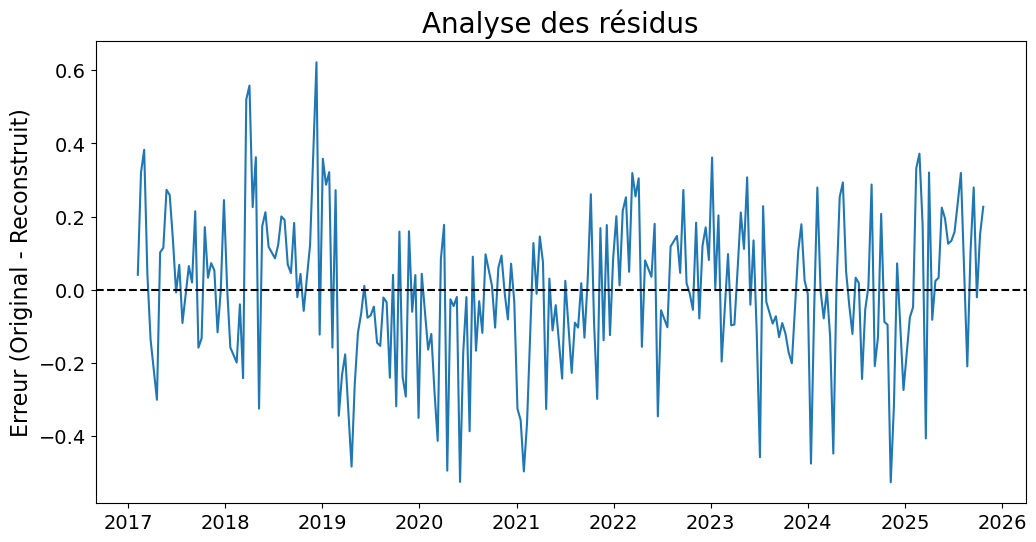

✔ Figure sauvegardée : figures_model\SAR_fit_2freq_lin_VH_DSC_Paracou_allROI_20170206_20251022.png


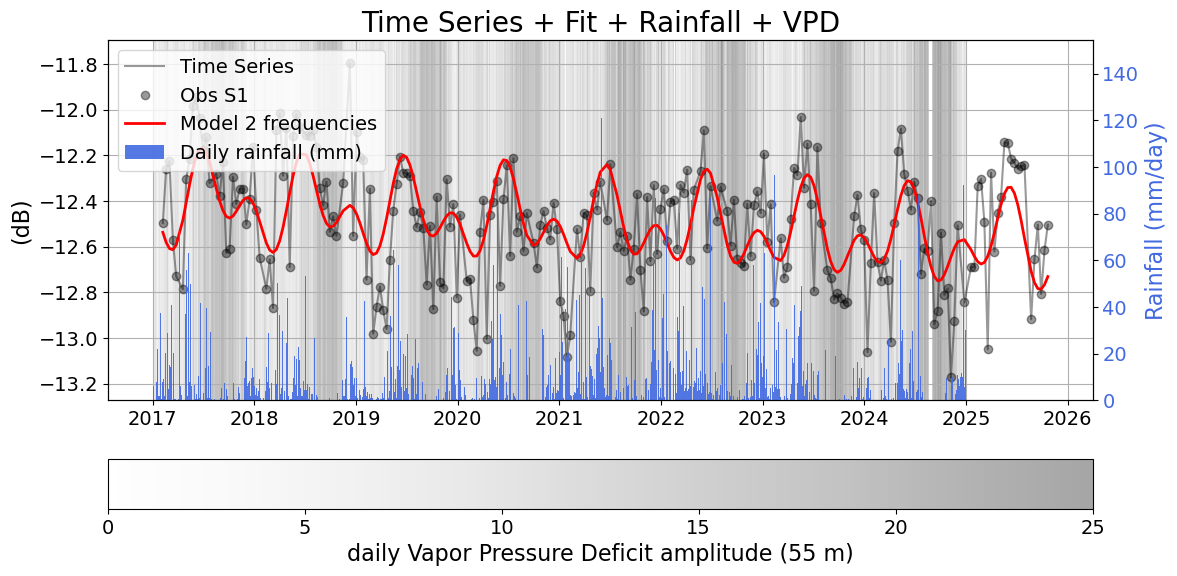

% === Table LaTeX générée pour VH_DSC (N=263, t=1.97) ===
\begin{tabular}{lccc}
\hline
 & Constant / Trend & Seasonal 1 & Seasonal 2 \\
\hline
% --- Trend Parameters ---
a (offset) & $-12.3936 \pm 0.0529$ & -- & -- \\
b (linear trend) & $-6.3\times10^{-5} \pm 3\times10^{-5}$ & -- & -- \\
\hline
% --- Seasonal Parameters ---
A (cos) & -- & $0.0183 \pm 0.0740$ & $-0.1271 \pm 0.0383$ \\
B (sin) & -- & $-0.1271 \pm 0.0384$ & $-0.0161 \pm 0.0748$ \\
Amplitude & -- & $0.1284$ & $0.1282$ \\
$\omega$ (rad/day) & -- & $0.0176 \pm 0.0003$ & $0.0345 \pm 0.0003$ \\
\hline
\end{tabular}
% Note: t-value used: 1.969 for df=257
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.272
p-value associée = 1.4896496718040988e-05


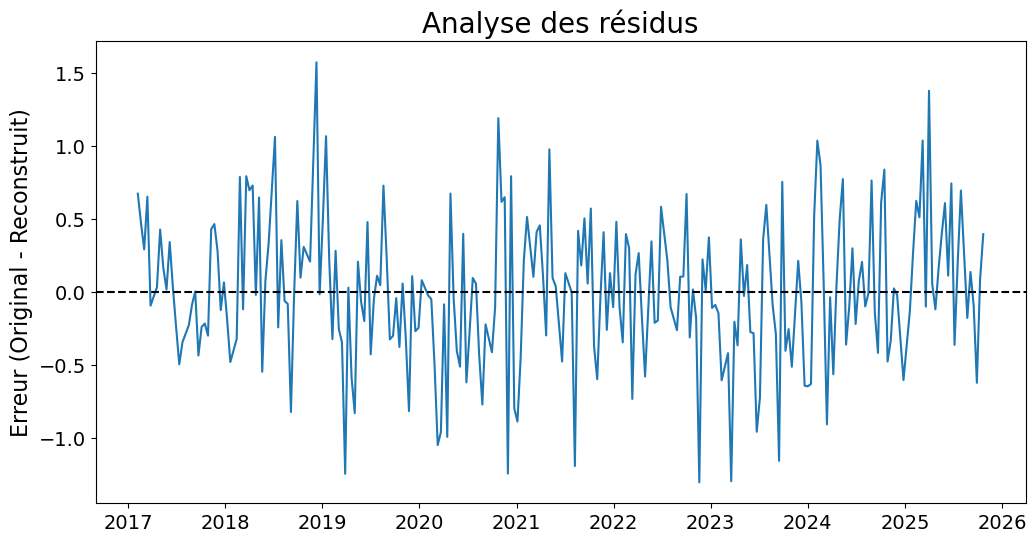

✔ Figure sauvegardée : figures_model\SAR_fit_ROI_2freq_lin_VH_DSC_TropiScat_20170206_20251022.png


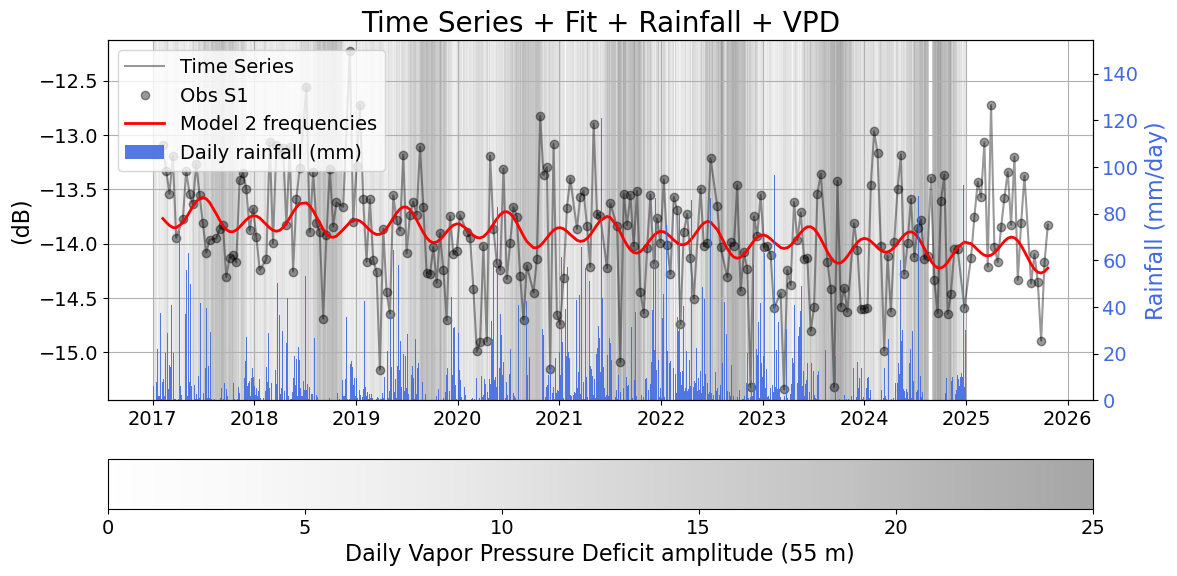

% === Table LaTeX générée pour VH_DSC_Tropiscat (N=263, t=1.97) ===
\begin{tabular}{lc}
\hline
 & Constant / Trend \\
\hline
% --- Trend Parameters ---
a (offset) & $-12.3936 \pm 0.1271$ \\
b (linear trend) & $-6.3\times10^{-5} \pm 7\times10^{-5}$ \\
\hline
% --- Seasonal Parameters ---
A (cos) & -- \\
B (sin) & -- \\
Amplitude & -- \\
$\omega$ (rad/day) & -- \\
\hline
\end{tabular}
% Note: t-value used: 1.969 for df=257


In [13]:
import lib
importlib.reload(lib)
from lib import *

####    VH DSC    ####

top_periodes = [365,180]    # Périodes d'initialisation
omega_2freq = [2*np.pi/T for T in top_periodes]     # Conversion en pulsations
top_periodes_large = [365,180,75,50]    # De même dans le cas où on utiliserait 4 fréquences
omega_4freq = [2*np.pi/T for T in top_periodes_large]

# fit sur toutes les ROIs
w_vh,sigma,fitted_params_VH_DSC,all_parameters_VH_DSC = fit_curve_n_freq(df_VH_DSC_allROI,df_gx_daily, omega_2freq,nom="VH_DSC_Paracou_allROI", n_freq=2)

affichage_incertitudes_latex(fitted_params_VH_DSC,sigma,w_vh,"VH_DSC")

# fit sur TropiScat (pulsations fixées)
sigma_fixed,params_VH_DSC = fit_curve_n_freq_fixed(df_VH_DSC_TropiScat,df_gx_daily, w_vh, fitted_params_VH_DSC, nom="VH_DSC_TropiScat")

affichage_incertitudes_latex(fitted_params_VH_DSC,sigma_fixed,[],"VH_DSC_Tropiscat")

t days: [3060 3072 3084 3096 3120 3132 3144 3156 3168]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.584
p-value associée = 7.158100479776009e-24


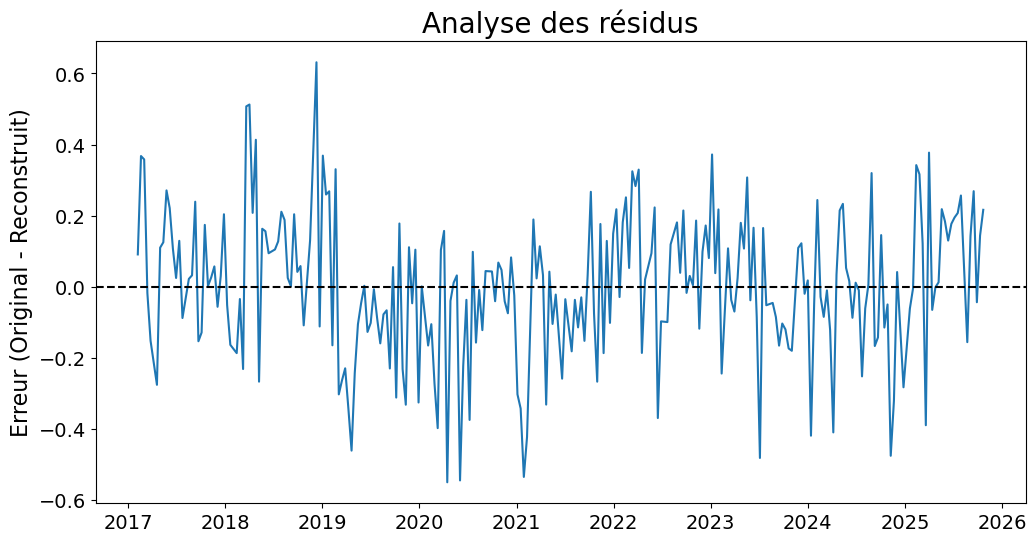

✔ Figure sauvegardée : figures_model\SAR_fit_4freq_lin_VH_DSC_Paracou_allROI_20170206_20251022.png


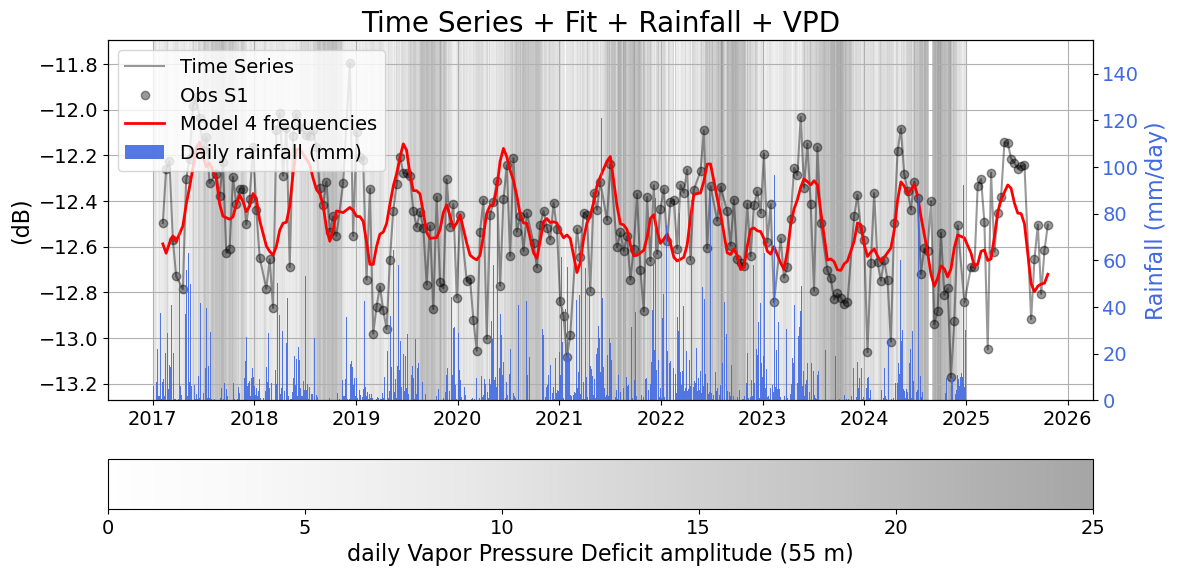

% === Table LaTeX générée pour VH_DSC (N=263, t=1.97) ===
\begin{tabular}{lccccc}
\hline
 & Constant / Trend & Seasonal 1 & Seasonal 2 & Seasonal 3 & Seasonal 4 \\
\hline
% --- Trend Parameters ---
a (offset) & $-12.3921 \pm 0.0531$ & -- & -- & -- & -- \\
b (linear trend) & $-6.4\times10^{-5} \pm 3\times10^{-5}$ & -- & -- & -- & -- \\
\hline
% --- Seasonal Parameters ---
A (cos) & -- & $0.0154 \pm 0.0743$ & $-0.1270 \pm 0.0381$ & $-0.0087 \pm 0.0750$ & $-0.0224 \pm 0.0551$ \\
B (sin) & -- & $-0.1275 \pm 0.0382$ & $-0.0142 \pm 0.0749$ & $-0.0365 \pm 0.0403$ & $-0.0171 \pm 0.0624$ \\
Amplitude & -- & $0.1285$ & $0.1278$ & $0.0375$ & $0.0282$ \\
$\omega$ (rad/day) & -- & $0.0176 \pm 0.0003$ & $0.0345 \pm 0.0003$ & $0.0844 \pm 0.0011$ & $0.1272 \pm 0.0014$ \\
\hline
\end{tabular}
% Note: t-value used: 1.969 for df=253
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.303
p-value associée = 1.3126938950504687e-06


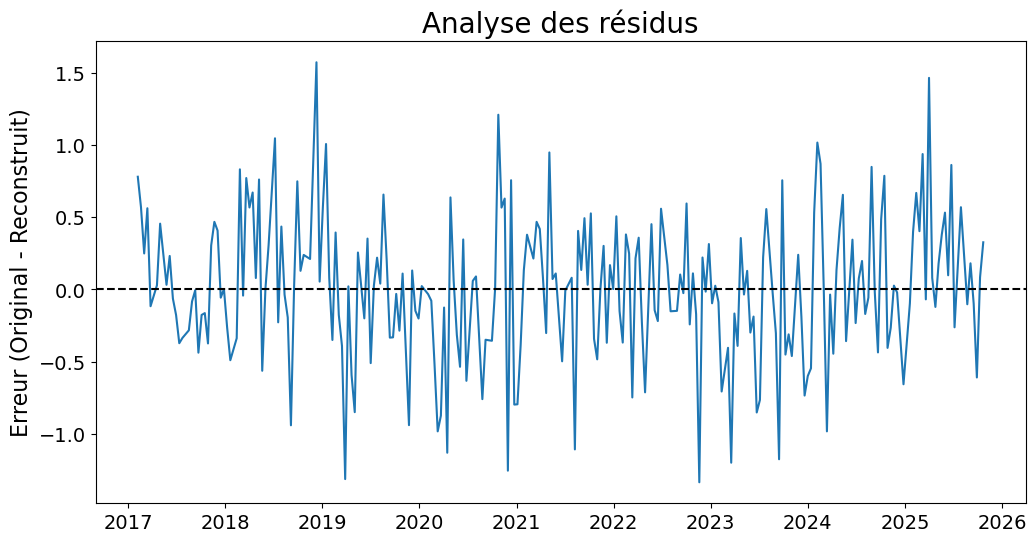

✔ Figure sauvegardée : figures_model\SAR_fit_ROI_4freq_lin_VH_DSC_TropiScat_20170206_20251022.png


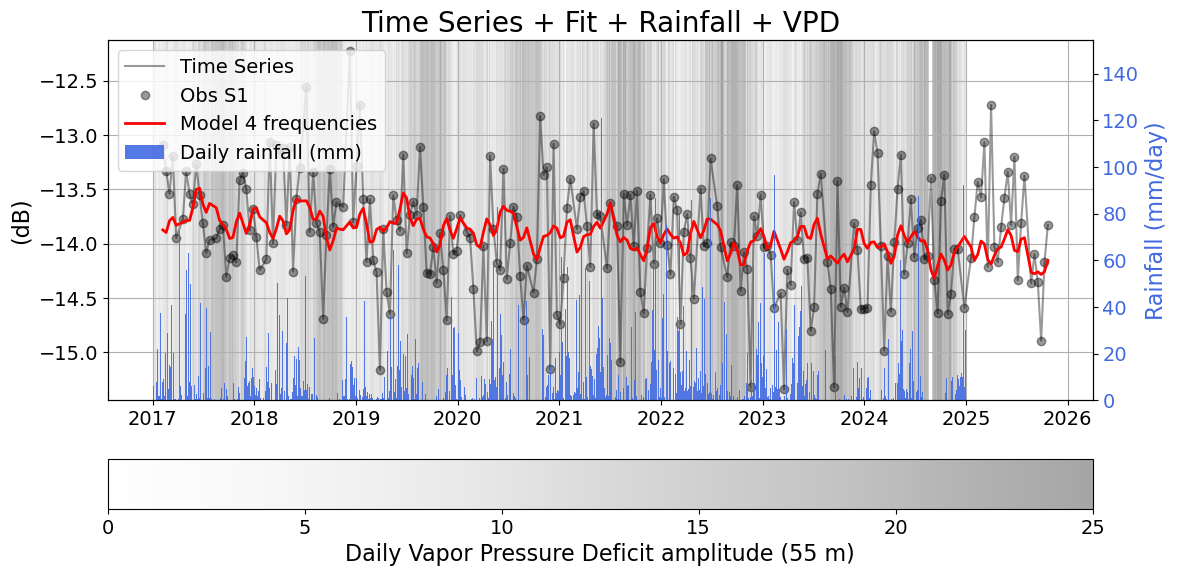

In [15]:
####    VH DSC    ####

w,sigma,fitted_params_VH_DSC_4,all_parameters_VH_DSC_4 = fit_curve_n_freq(df_VH_DSC_allROI,df_gx_daily, omega_4freq,nom="VH_DSC_Paracou_allROI", n_freq=4)

affichage_incertitudes_latex(fitted_params_VH_DSC_4,sigma,w,"VH_DSC")

sigma_fixed,params_VH_DSC = fit_curve_n_freq_fixed(df_VH_DSC_TropiScat,df_gx_daily, w, fitted_params_VH_DSC_4, nom="VH_DSC_TropiScat")

## Différence entre VV et VH

Fit des paramètres VV

t days: [3060 3072 3084 3096 3120 3132 3144 3156 3168]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.676
p-value associée = 1.6161011338644486e-34


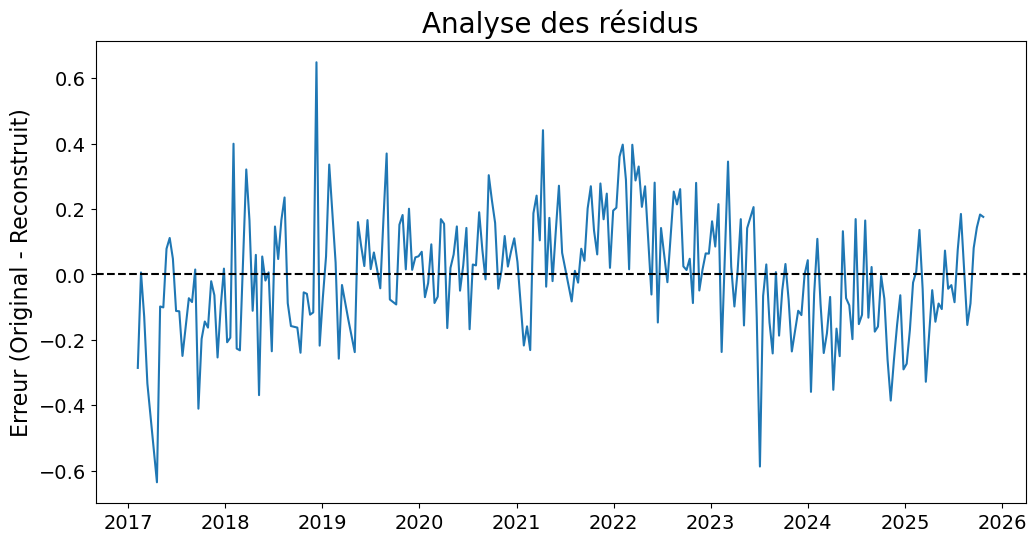

✔ Figure sauvegardée : figures_model\SAR_fit_2freq_lin_VV_DSC_Paracou_allROI_20170206_20251022.png


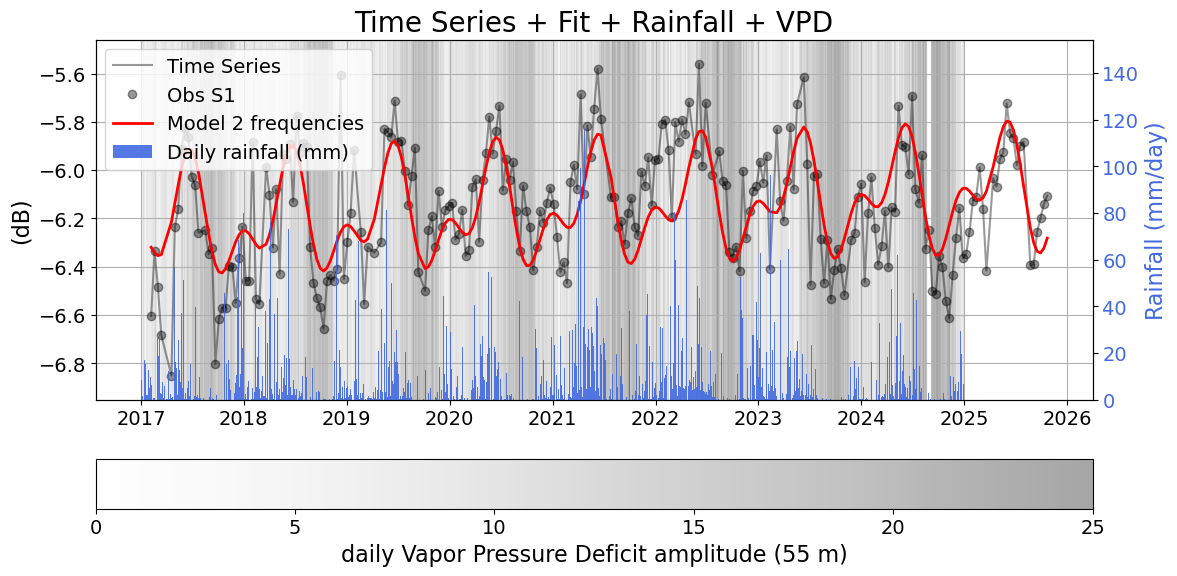

fitted_params_VV_DSC [np.float64(-6.229982357029891), np.float64(4.997509036105454e-05), np.float64(0.147314036176794), np.float64(-0.10631482581866455), np.float64(-0.13464954673985763), np.float64(0.016957176978380138)]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.285
p-value associée = 5.1574556040269006e-06


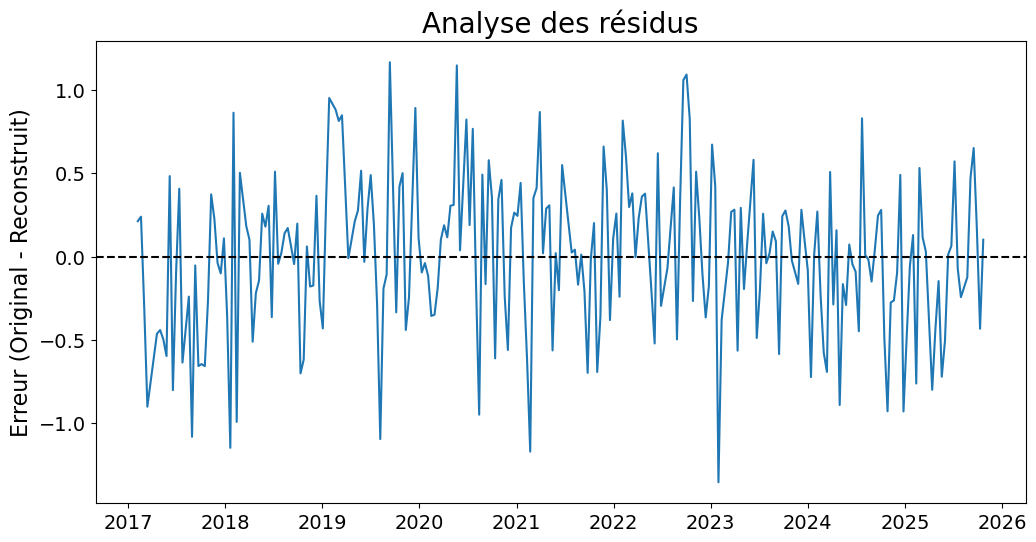

✔ Figure sauvegardée : figures_model\SAR_fit_ROI_2freq_lin_VV_DSC_TropiScat_20170206_20251022.png


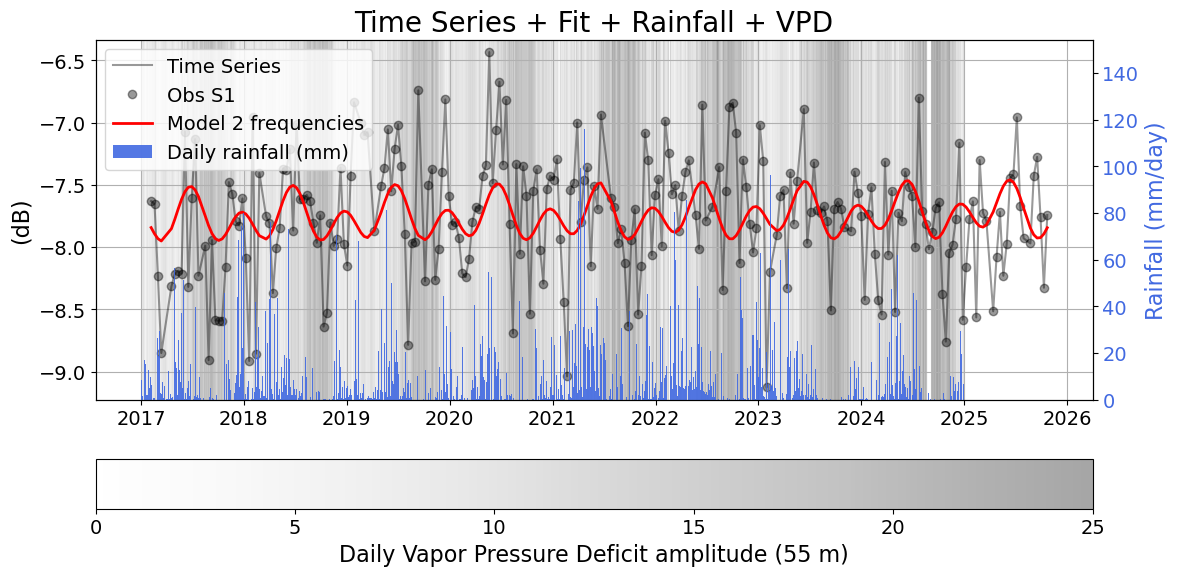

In [16]:
w_vv,sigma,fitted_params_VV_DSC,all_parameters_VV_DSC = fit_curve_n_freq(df_VV_DSC_allROI,df_gx_daily, omega_2freq, nom="VV_DSC_Paracou_allROI", n_freq=2)

print("fitted_params_VV_DSC",fitted_params_VV_DSC)

# fit sur TropiScat (pulsations fixées)
sigma_fixed,params_VV_DSC = fit_curve_n_freq_fixed(df_VV_DSC_TropiScat,df_gx_daily, w_vv, fitted_params_VV_DSC, nom="VV_DSC_TropiScat")

In [17]:
import lib
importlib.reload(lib)
from lib import *

Corrélation VH_DSC–VV_DSC reconstruite vs observée = 0.562


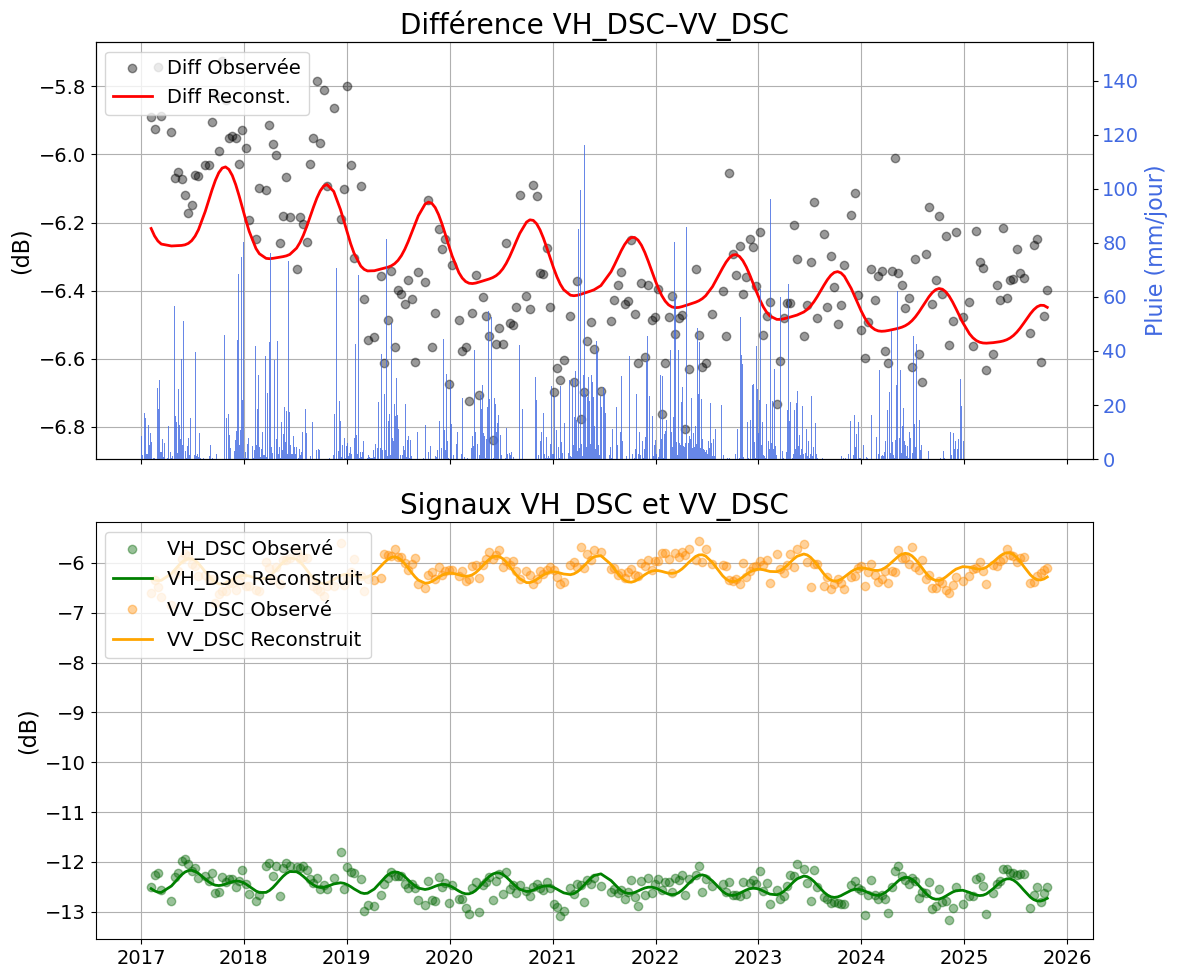

In [18]:
# Sur toutes les ROIs
afficher_diff_signaux(
    df1=df_VH_DSC_allROI,
    df2=df_VV_DSC_allROI,
    params1=all_parameters_VH_DSC,
    params2=all_parameters_VV_DSC,
    df_gx_daily=df_gx_daily,
    noms=["VH_DSC","VV_DSC"]
)

In [19]:
import lib
importlib.reload(lib)
from lib import *

corr de Pearson entre signal reconstruit et signal original = 0.232


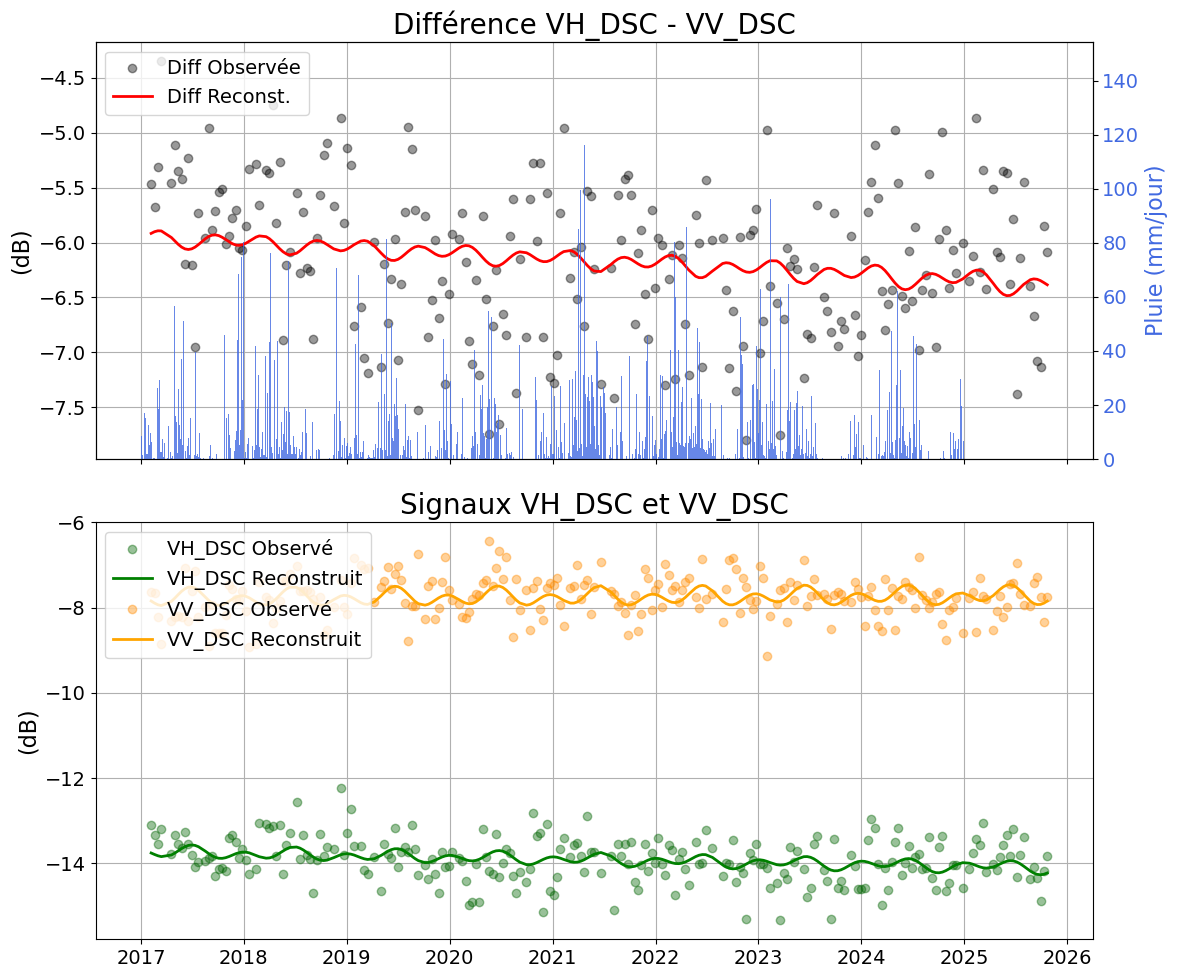

In [20]:
# Sur TropiScat
afficher_diff_signaux_fixe(
    df1=df_VH_DSC_TropiScat,
    df2=df_VV_DSC_TropiScat,
    w1=w_vh,
    params1=params_VH_DSC,
    w2=w_vv,
    params2=params_VV_DSC,
    df_gx_daily=df_gx_daily,
    noms=["VH_DSC","VV_DSC"]
)

## Différence entre ASC et DSC

t days: [3084 3096 3108 3120 3144 3156 3168 3180 3192]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.530
p-value associée = 6.595616880763227e-19


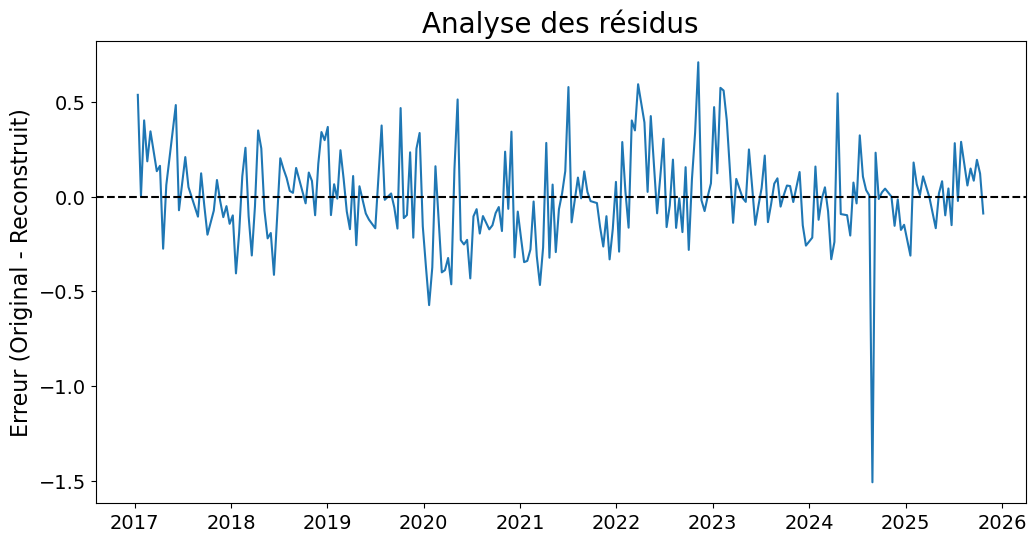

✔ Figure sauvegardée : figures_model\SAR_fit_2freq_lin_VH_ASC_Paracou_allROI_20170113_20251022.png


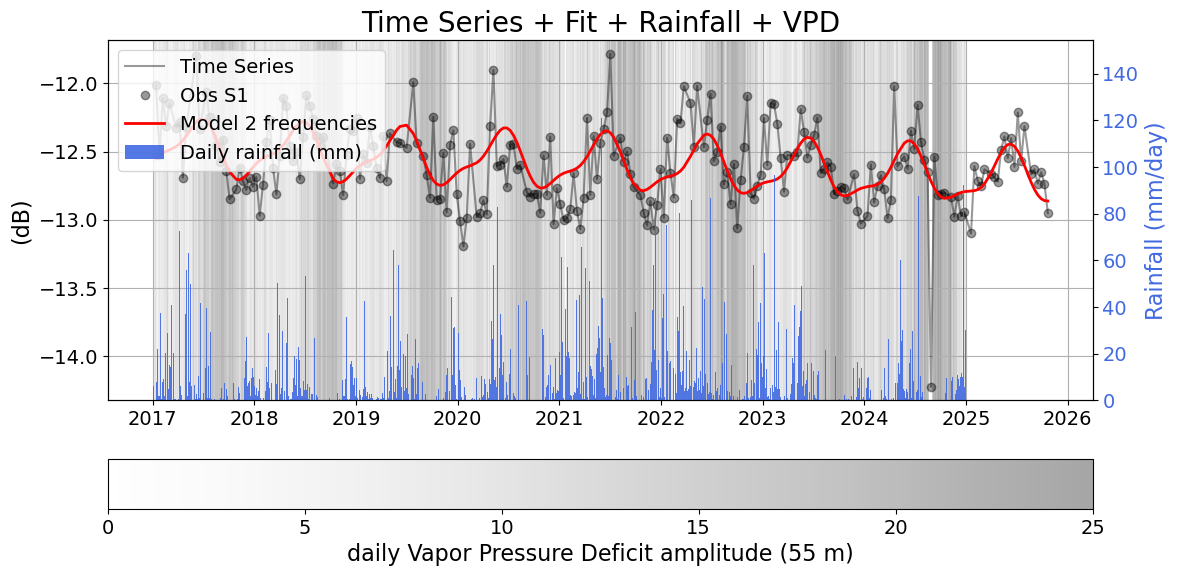

fitted_params_VH_ASC [np.float64(-12.472763086892668), np.float64(-7.282275122702427e-05), np.float64(0.11866247586140738), np.float64(-0.14544073848132377), np.float64(0.006689003247371498), np.float64(0.06684788356138484)]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.187
p-value associée = 0.0035730093096876057


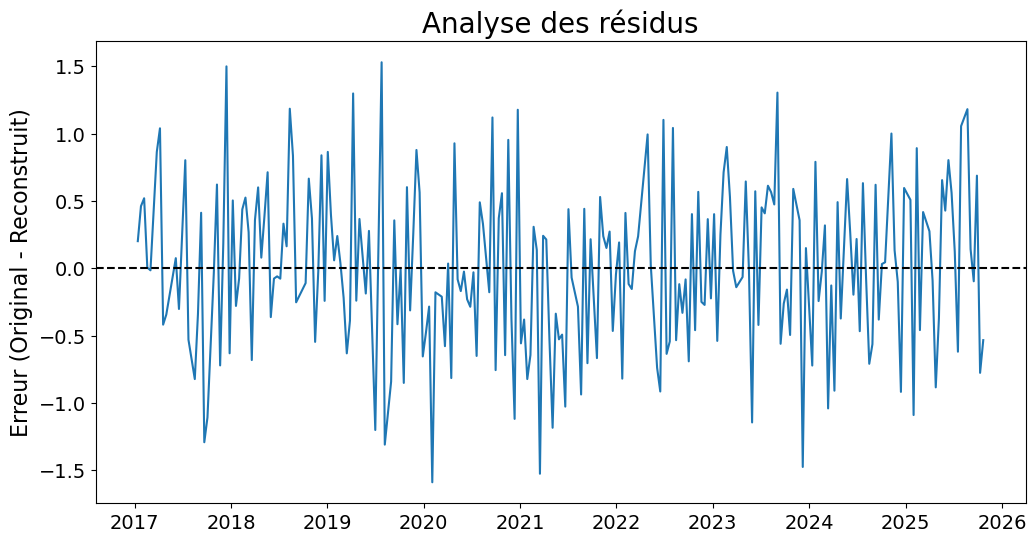

✔ Figure sauvegardée : figures_model\SAR_fit_ROI_2freq_lin_VH_ASC_TropiScat_20170113_20251022.png


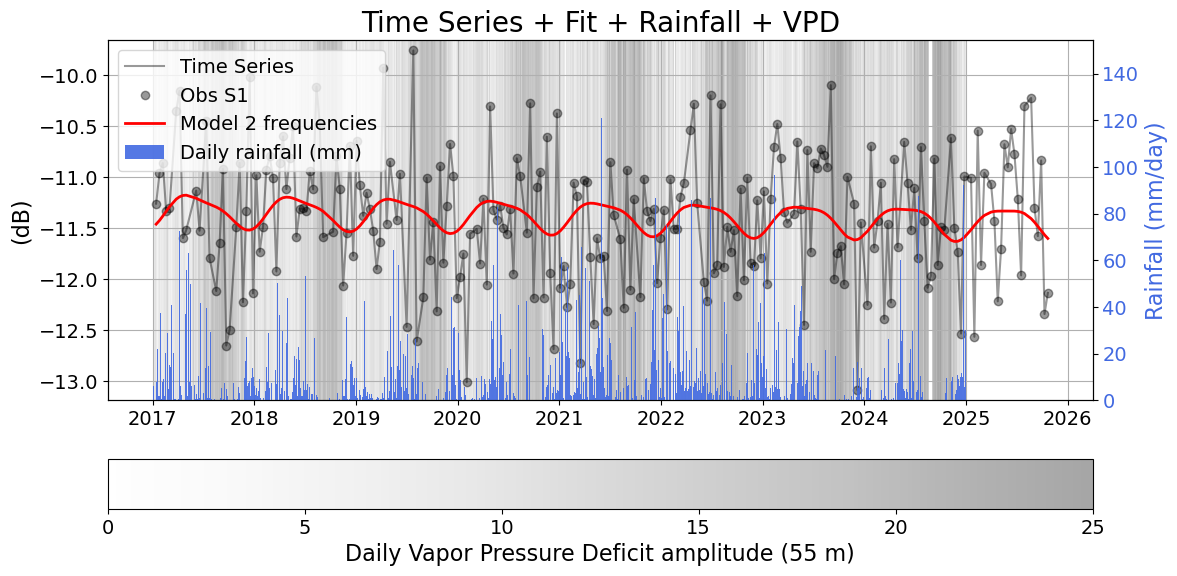

In [21]:
w_vv,sigma,fitted_params_VH_ASC,all_parameters_VH_ASC = fit_curve_n_freq(df_VH_ASC_allROI,df_gx_daily, omega_2freq, nom="VH_ASC_Paracou_allROI", n_freq=2)

print("fitted_params_VH_ASC",fitted_params_VH_ASC)

# fit sur TropiScat (pulsations fixées)
sigma_fixed,params_VH_ASC = fit_curve_n_freq_fixed(df_VH_ASC_TropiScat,df_gx_daily, w_vv, fitted_params_VH_ASC, nom="VH_ASC_TropiScat")

Corrélation VH_ASC–VH_DSC reconstruite vs observée = 0.252


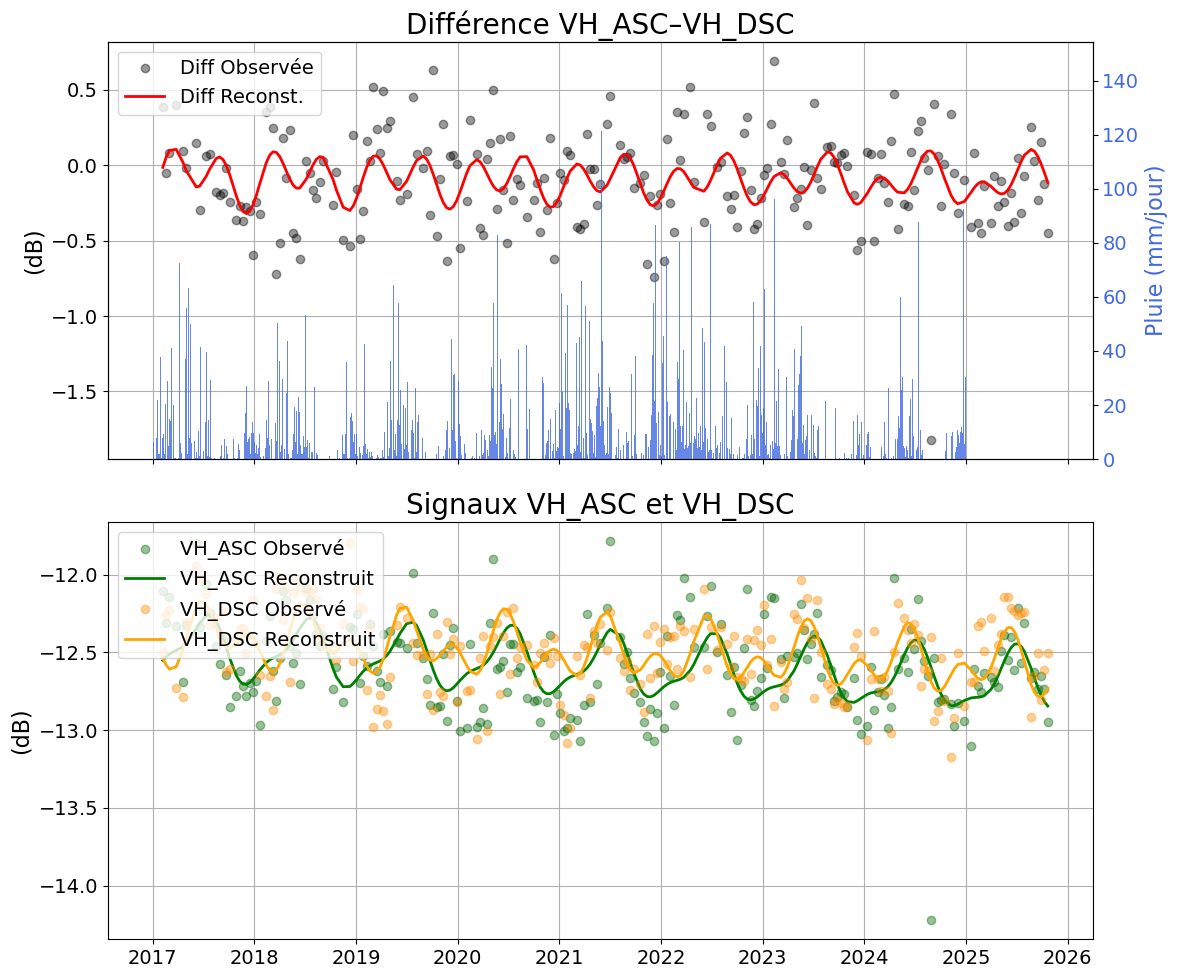

In [22]:
# Sur toutes les ROIs
afficher_diff_signaux(
    df1=df_VH_ASC_allROI,
    df2=df_VH_DSC_allROI,
    params1=all_parameters_VH_ASC,
    params2=all_parameters_VH_DSC,
    df_gx_daily=df_gx_daily,
    noms=["VH_ASC","VH_DSC"]
)

corr de Pearson entre signal reconstruit et signal original = 0.099


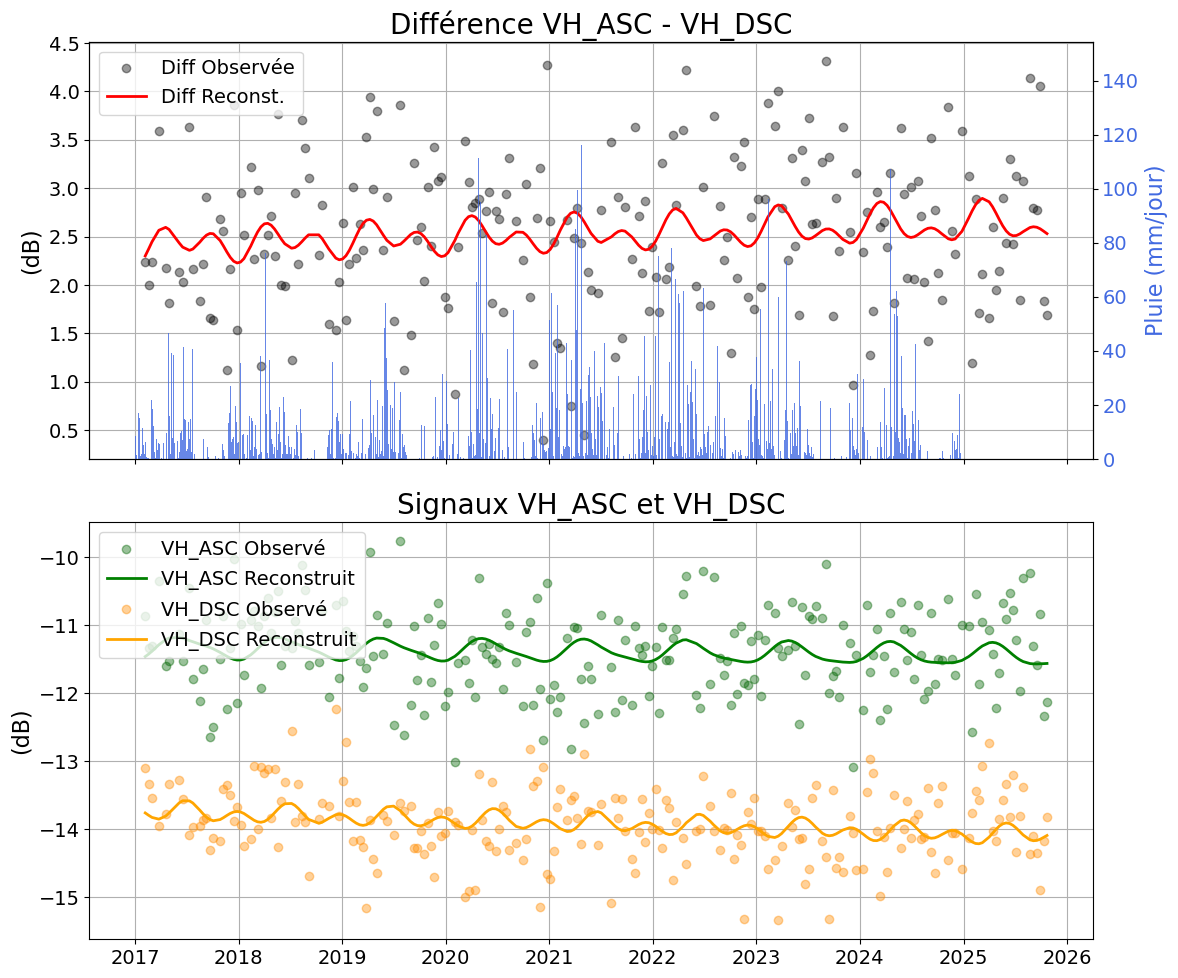

In [23]:
# Sur TropiScat
afficher_diff_signaux_fixe(
    df1=df_VH_ASC_TropiScat,
    df2=df_VH_DSC_TropiScat,
    w1=w_vh,
    params1=params_VH_ASC,
    w2=w_vv,
    params2=params_VH_DSC,
    df_gx_daily=df_gx_daily,
    noms=["VH_ASC","VH_DSC"]
)

## ALOS

df_ALOS_HV_allROI
df_ALOS_HH_allROI
df_ALOS_HV_TropiScat
df_ALOS_HH_TropiScat

In [24]:
#psd_welch_annee(df_ALOS_HV_allROI, window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90])

In [25]:
#psd_welch_annee(df_ALOS_HH_allROI, window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90])

In [26]:
#df_ALOS_HV_allROI
#df_ALOS_HH_allROI
#df_ALOS_HV_TropiScat
#df_ALOS_HH_TropiScat

In [27]:
# top_periodes_HV = [220,115]    # Périodes d'initialisation
# omega_2freq_HV = [2*np.pi/T for T in top_periodes_HV]     # Conversion en pulsations

# top_periodes_HH = [450,135]    # Périodes d'initialisation
# omega_2freq_HH = [2*np.pi/T for T in top_periodes_HH]     # Conversion en pulsations

# top_periodes_large_HH = [450,135,65,35]    # De même dans le cas où on utiliserait 4 fréquences
# omega_4freq_HH = [2*np.pi/T for T in top_periodes_large_HH]

# # fit sur toutes les ROIs
# w_vh,sigma,fitted_params_VH_DSC,all_parameters_VH_DSC = fit_curve_n_freq(df_ALOS_HV_allROI,df_gx_daily, omega_2freq_HV, n_freq=2)

# affichage_incertitudes(fitted_params_VH_DSC,sigma,w_vh,"HV_ALOS_allROI")

# # fit sur TropiScat (pulsations fixées)
# sigma_fixed,params_VH_DSC = fit_curve_n_freq_fixed(df_ALOS_HV_TropiScat,df_gx_daily, w_vh, fitted_params_VH_DSC)

# affichage_incertitudes(fitted_params_VH_DSC,sigma_fixed,[],"HV_ALOS_TropiScat")

In [28]:
# w_vh,sigma,fitted_params_HH,all_parameters_HH = fit_curve_n_freq(df_ALOS_HH_allROI,df_gx_daily, omega_2freq_HH, n_freq=2)

# affichage_incertitudes(fitted_params_HH,sigma,w_vh,"HH_ALOS_allROI")

# # fit sur TropiScat (pulsations fixées)
# sigma_fixed,params_HH = fit_curve_n_freq_fixed(df_ALOS_HH_TropiScat,df_gx_daily, w_vh, fitted_params_HH)

# affichage_incertitudes(fitted_params_HH,sigma_fixed,[],"HH_ALOS_TropiScat")

# ZONES DEFOLI2ES :

In [29]:
import lib
importlib.reload(lib)
from lib import *

In [30]:
dfs_defol = {
    "defol_VV_allROI": df_defol_VV_allROI,
    "intact_VV_allROI": df_intact_VV_allROI,
    "defol_VH_allROI": df_defol_VH_allROI,
    "intact_VH_allROI": df_intact_VH_allROI,
}

dfs_defol_ROI = {
    "defol_VV_ROI": df_defol_VV_ROI,
    "std_defol_VV_ROI": df_std_defol_VV_ROI,
}


===== Overlap Analysis = 70% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.152), np.float64(0.123), np.float64(0.282), np.float64(0.986)] years or, [ 55.38461538  45.         102.85714286 360.        ]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.308), np.float64(0.493), np.float64(0.822)] years or, [ 47.36842105 112.5        180.         300.        ]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.299), np.float64(0.499), np.float64(0.997)] years or, [ 47.47826087 109.2        182.         364.        ]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.129), np.float64(0.29), np.float64(0.498), np.float64(0.871)] years or, [ 47.11111111 106.         181.71428571 318.        ]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.128), np.float64(0.284), np.float64(0.497), np.float64(0.995)] years or, [ 46.83870968 103.71428571 181.5        363.        ]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_

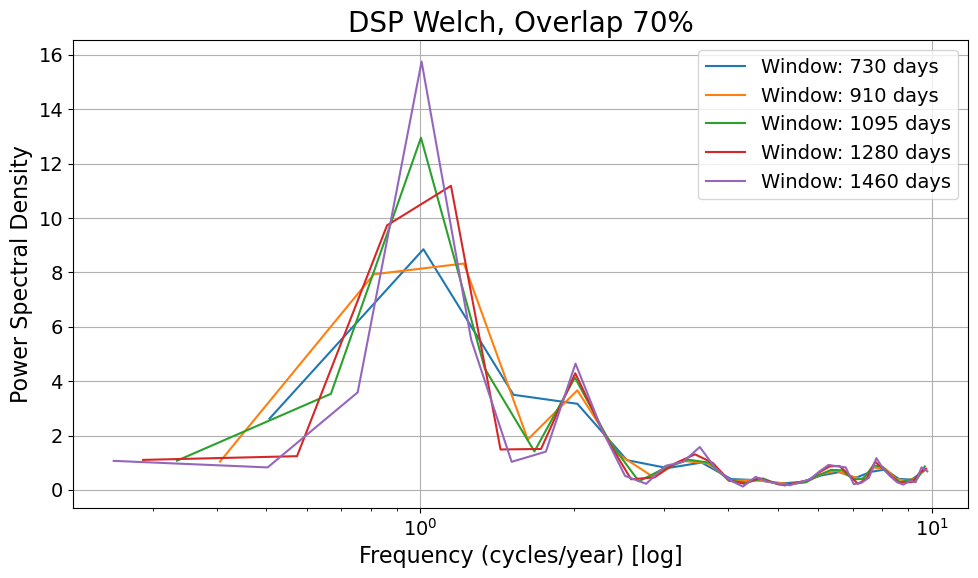


===== Overlap Analysis = 80% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.152), np.float64(0.123), np.float64(0.282), np.float64(0.986)] years or, [ 55.38461538  45.         102.85714286 360.        ]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.308), np.float64(0.493), np.float64(0.822)] years or, [ 47.36842105 112.5        180.         300.        ]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.299), np.float64(0.499), np.float64(0.997)] years or, [ 47.47826087 109.2        182.         364.        ]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.129), np.float64(0.29), np.float64(0.498), np.float64(0.871)] years or, [ 47.11111111 106.         181.71428571 318.        ]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.128), np.float64(0.284), np.float64(0.497), np.float64(0.995)] years or, [ 46.83870968 103.71428571 181.5        363.        ]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_

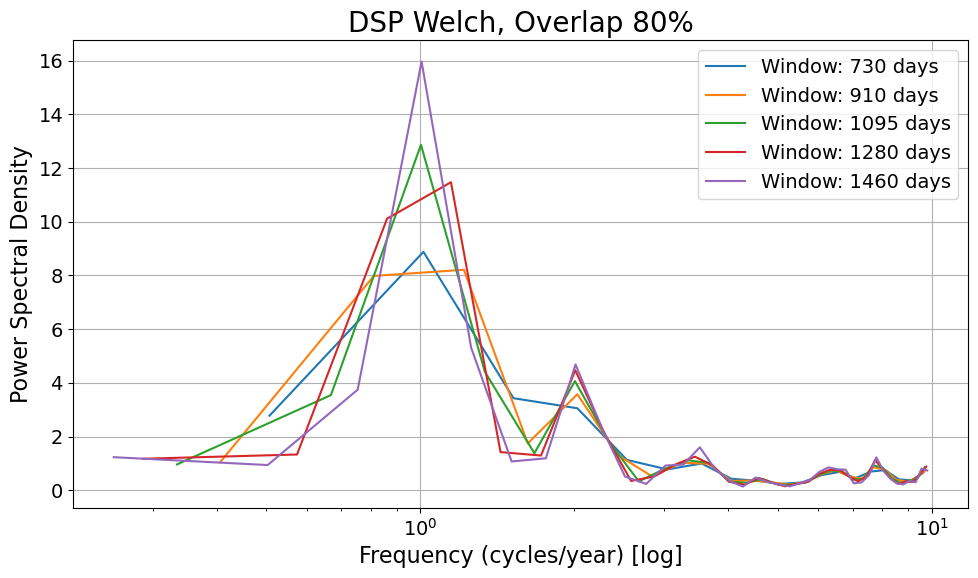


===== Overlap Analysis = 90% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.152), np.float64(0.123), np.float64(0.282), np.float64(0.986)] years or, [ 55.38461538  45.         102.85714286 360.        ]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.308), np.float64(0.493), np.float64(0.822)] years or, [ 47.36842105 112.5        180.         300.        ]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.299), np.float64(0.499), np.float64(0.997)] years or, [ 47.47826087 109.2        182.         364.        ]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.129), np.float64(0.29), np.float64(0.498), np.float64(0.871)] years or, [ 47.11111111 106.         181.71428571 318.        ]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.128), np.float64(0.284), np.float64(0.497), np.float64(0.995)] years or, [ 46.83870968 103.71428571 181.5        363.        ]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_

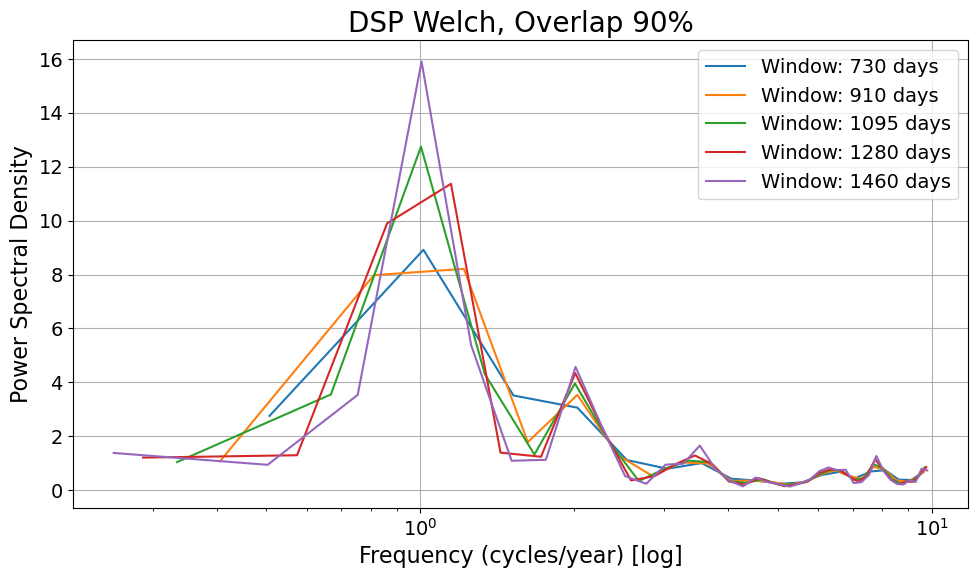

In [31]:
#psd_welch_annee(df_intact_VV_allROI, window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90],n_peaks=4)

psd_welch_annee(df_intact_VV_allROI, "VV_intact_allROI", window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90],n_peaks=4, outdir="figures_welch", prefix="PSD", show=True)


===== Overlap Analysis = 70% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.152), np.float64(0.123), np.float64(0.282), np.float64(0.986)] years or, [ 55.38461538  45.         102.85714286 360.        ]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.308), np.float64(0.493), np.float64(0.822)] years or, [ 47.36842105 112.5        180.         300.        ]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.299), np.float64(0.499), np.float64(0.997)] years or, [ 47.47826087 109.2        182.         364.        ]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.29), np.float64(0.129), np.float64(0.498), np.float64(0.871)] years or, [106.          47.11111111 181.71428571 318.        ]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.284), np.float64(0.128), np.float64(0.497), np.float64(0.995)] years or, [103.71428571  46.83870968 181.5        363.        ]  days


✔ Figure sauvegardée : figures_welch\PSD_overlap_70pct_VV_defol_allROI.png


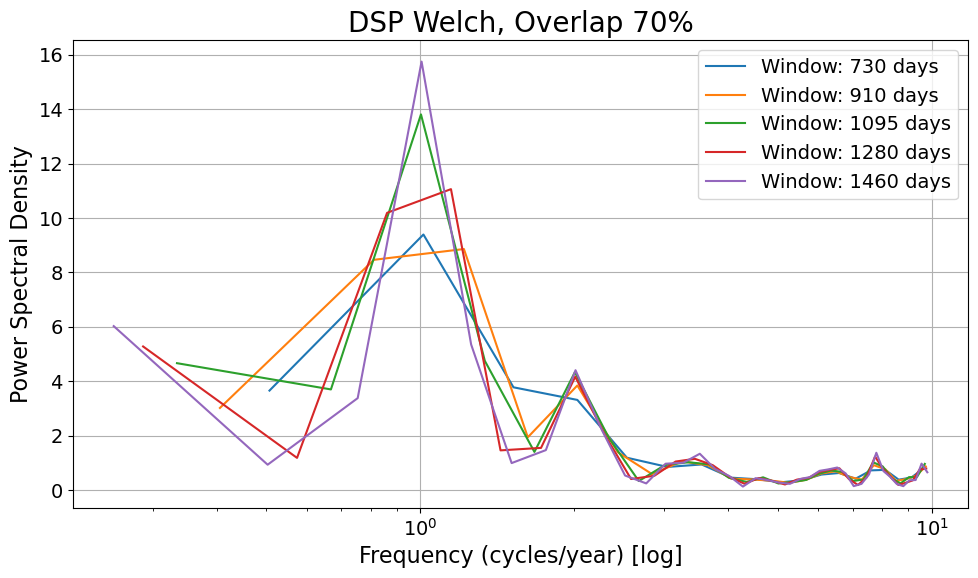


===== Overlap Analysis = 80% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.152), np.float64(0.123), np.float64(0.282), np.float64(0.986)] years or, [ 55.38461538  45.         102.85714286 360.        ]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.308), np.float64(0.493), np.float64(0.822)] years or, [ 47.36842105 112.5        180.         300.        ]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.299), np.float64(0.13), np.float64(0.499), np.float64(0.997)] years or, [109.2         47.47826087 182.         364.        ]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.29), np.float64(0.129), np.float64(0.498), np.float64(0.871)] years or, [106.          47.11111111 181.71428571 318.        ]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.284), np.float64(0.128), np.float64(0.497), np.float64(0.995)] years or, [103.71428571  46.83870968 181.5        363.        ]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_

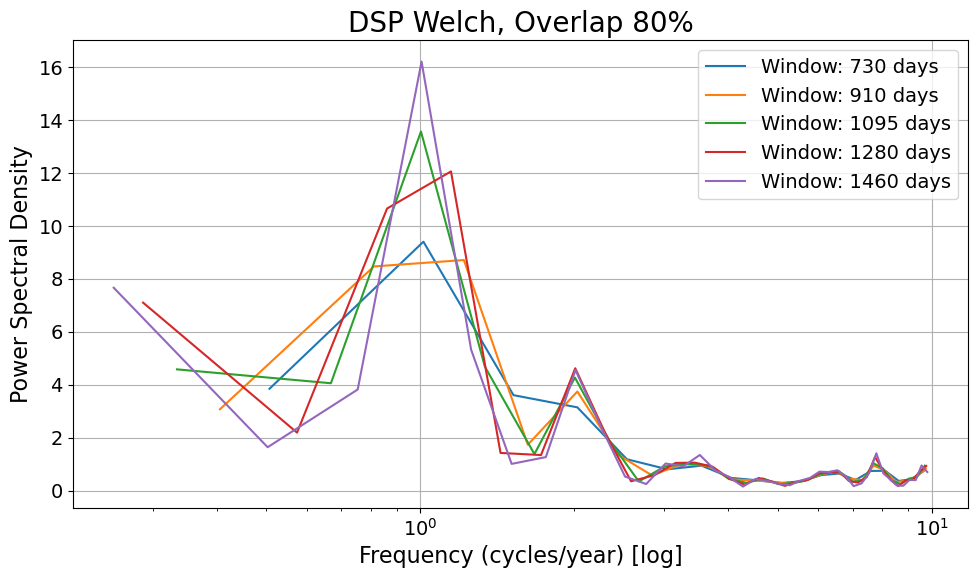


===== Overlap Analysis = 90% =====
 WL = 730 days — Dominant periods ≈ [np.float64(0.152), np.float64(0.132), np.float64(0.282), np.float64(0.986)] years or, [ 55.38461538  48.         102.85714286 360.        ]  days
 WL = 910 days — Dominant periods ≈ [np.float64(0.13), np.float64(0.308), np.float64(0.493), np.float64(0.822)] years or, [ 47.36842105 112.5        180.         300.        ]  days
 WL = 1095 days — Dominant periods ≈ [np.float64(0.299), np.float64(0.13), np.float64(0.499), np.float64(0.997)] years or, [109.2         47.47826087 182.         364.        ]  days
 WL = 1280 days — Dominant periods ≈ [np.float64(0.29), np.float64(0.129), np.float64(0.498), np.float64(0.871)] years or, [106.          47.11111111 181.71428571 318.        ]  days
 WL = 1460 days — Dominant periods ≈ [np.float64(0.284), np.float64(0.128), np.float64(0.497), np.float64(0.995)] years or, [103.71428571  46.83870968 181.5        363.        ]  days
✔ Figure sauvegardée : figures_welch\PSD_overlap_

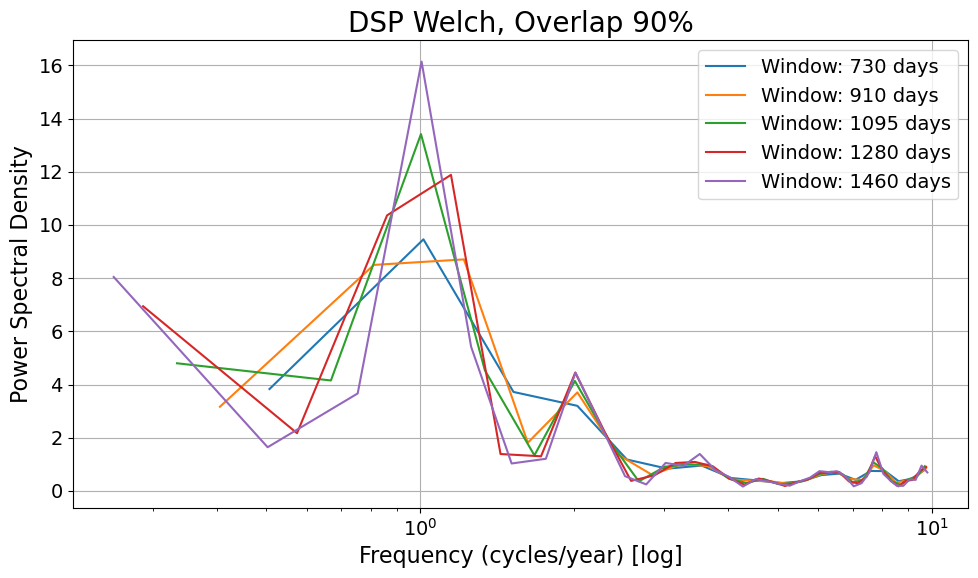

In [32]:
#psd_welch_annee(df_defol_VV_allROI, window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90],n_peaks=4)
psd_welch_annee(df_defol_VV_allROI, "VV_defol_allROI", window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90],n_peaks=4, outdir="figures_welch", prefix="PSD", show=True)

t days: [3096 3108 3120 3132 3144 3156 3168 3180 3192]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.725
p-value associée = 5.148742668359923e-44


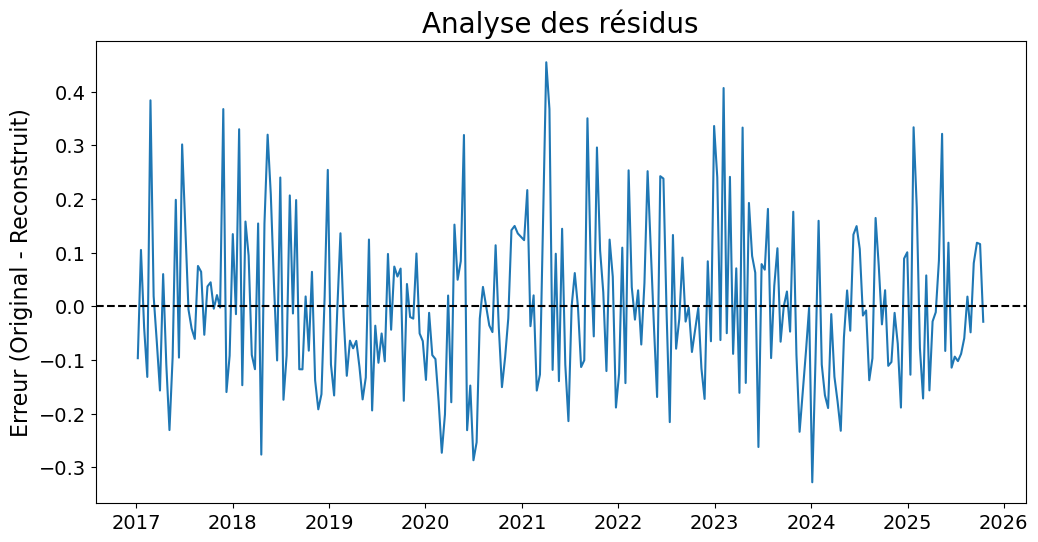

✔ Figure sauvegardée : figures_model\SAR_fit_2freq_quad_intact_allROI_20170106_20251015.png


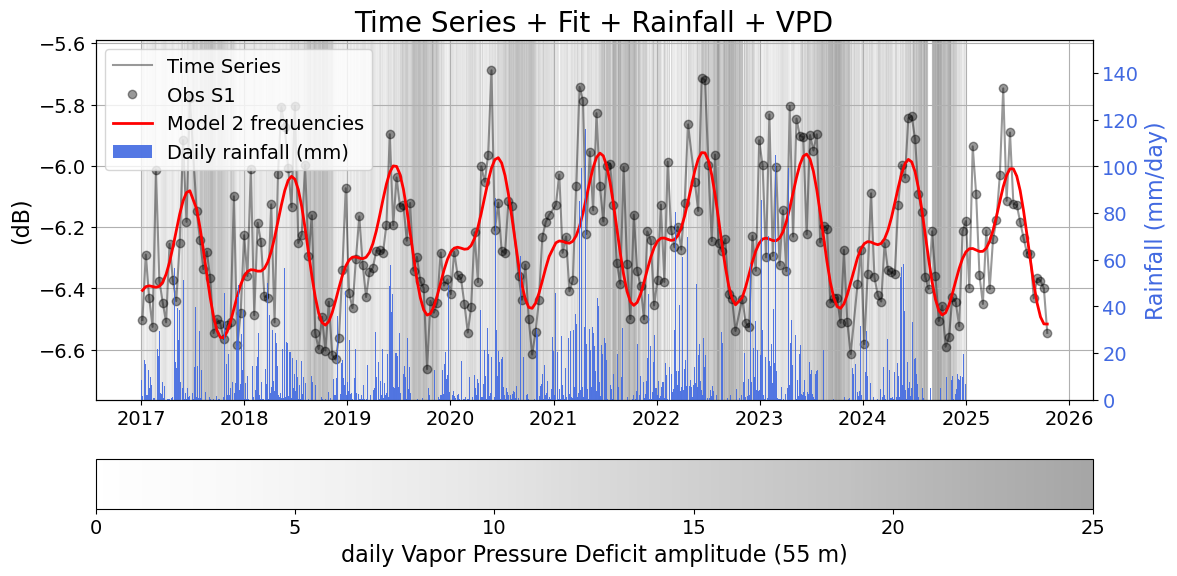

% === Table LaTeX générée pour VV_intact (N=263, t=1.97) ===
\begin{tabular}{lccc}
\hline
 & Constant / Trend & Seasonal 1 & Seasonal 2 \\
\hline
% --- Trend Parameters ---
a (offset) & $-6.3704 \pm 0.0554$ & -- & -- \\
b (linear trend) & $1.6\times10^{-4} \pm 1\times10^{-4}$ & -- & -- \\
\hline
% --- Seasonal Parameters ---
A (cos) & -- & $-4.0\times10^{-8} \pm 2\times10^{-8}$ & $-0.1372 \pm 0.0001$ \\
B (sin) & -- & $0.1250 \pm 0.0419$ & $-0.0245 \pm 0.0503$ \\
Amplitude & -- & $0.1250$ & $0.1394$ \\
$\omega$ (rad/day) & -- & $0.0173 \pm 0.0394$ & $0.0345 \pm 0.0277$ \\
\hline
\end{tabular}
% Note: t-value used: 1.969 for df=256
t days: [3096 3108 3120 3132 3144 3156 3168 3180 3192]
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.805
p-value associée = 5.272166236777626e-61


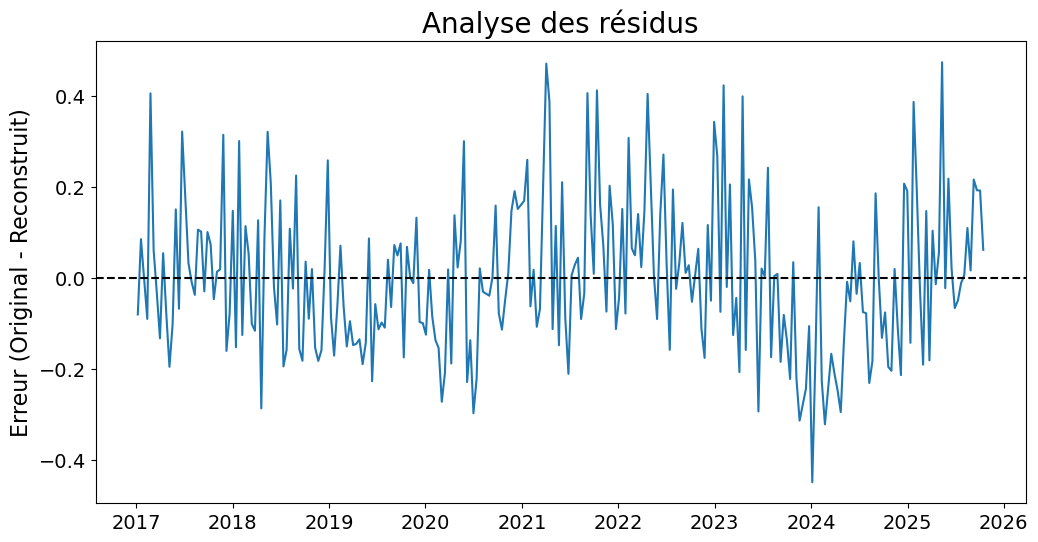

✔ Figure sauvegardée : figures_model\SAR_fit_2freq_quad_defol_allROI_20170106_20251015.png


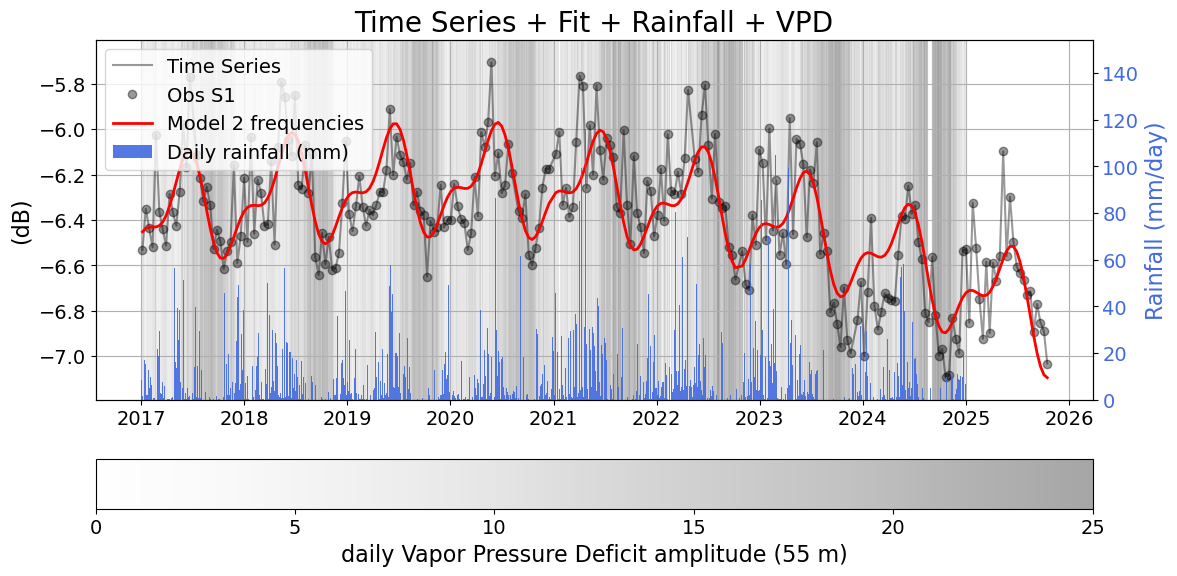

% === Table LaTeX générée pour VV_defol, modèle quadratique (N=263, t=1.97) ===
\begin{tabular}{lccc}
\hline
 & Constant / Trend & Seasonal 1 & Seasonal 2 \\
\hline
% --- Trend Parameters ---
a (offset) & $-6.4107 \pm 0.0625$ & -- & -- \\
b (linear trend) & $3.2\times10^{-4} \pm 1\times10^{-4}$ & -- & -- \\
c (quad trend) & $-1.4\times10^{-7} \pm 0\times10^{-7}$ & -- & -- \\
\hline
% --- Seasonal Parameters ---
A (cos) & -- & $0.1271 \pm 0.0476$ & $-0.0237 \pm 0.0569$ \\
B (sin) & -- & $-0.1426 \pm 0.0441$ & $0.1014 \pm 0.0311$ \\
Amplitude & -- & $0.1911$ & $0.1041$ \\
$\omega$ (rad/day) & -- & $0.0173 \pm 0.0002$ & $0.0344 \pm 0.0003$ \\
\hline
\end{tabular}
% Note: t-value used: 1.969 for df=256
coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.472
p-value associée = 6.744563404377519e-16


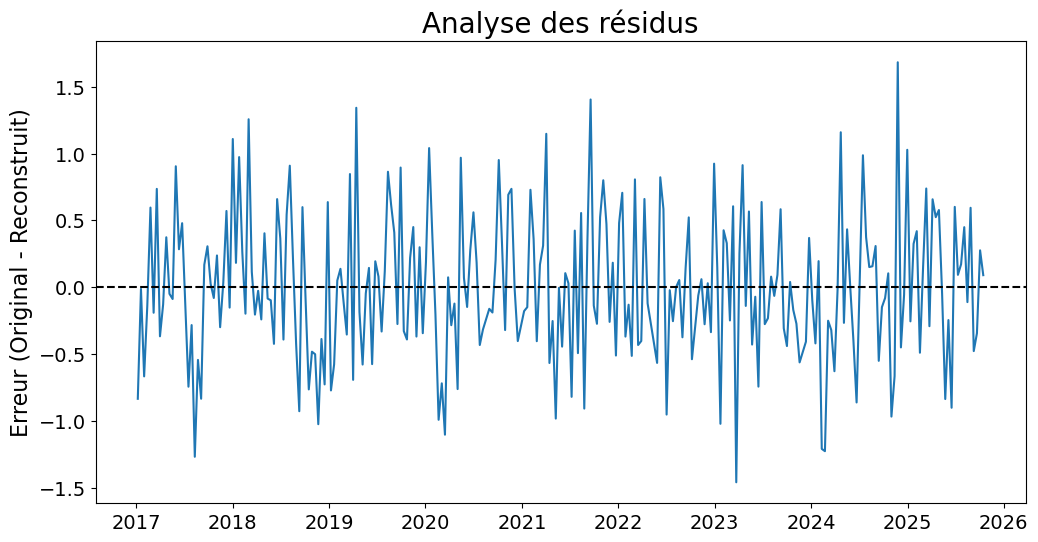

✔ Figure sauvegardée : figures_model\SAR_fit_ROI_2freq_quad_defol_1ha_20170106_20251015.png


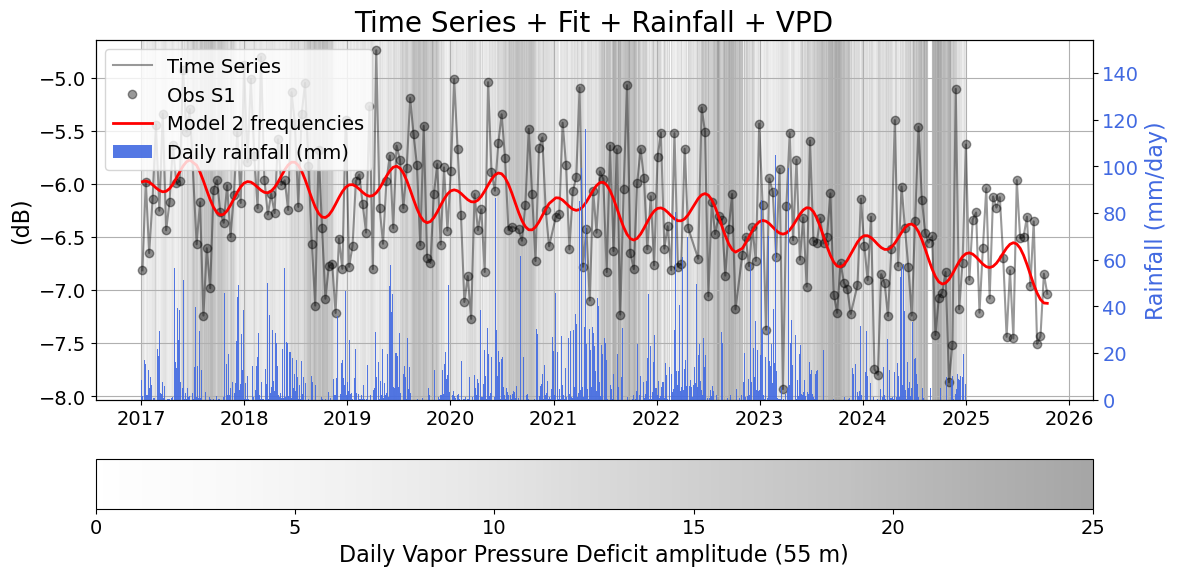

% === Table LaTeX générée pour defol_1ha (N=263, t=1.97) ===
\begin{tabular}{lc}
\hline
 & Constant / Trend \\
\hline
% --- Trend Parameters ---
a (offset) & $-6.0283 \pm 0.2016$ \\
b (linear trend) & $1.4\times10^{-5} \pm 29\times10^{-5}$ \\
c (quad trend) & $-8.5\times10^{-8} \pm 9\times10^{-8}$ \\
\hline
% --- Seasonal Parameters ---
A (cos) & -- \\
B (sin) & -- \\
Amplitude & -- \\
$\omega$ (rad/day) & -- \\
\hline
\end{tabular}
% Note: t-value used: 1.969 for df=256


In [34]:
####    VV    ####
import lib
importlib.reload(lib)
from lib import *

top_periodes = [365,180]    # Périodes d'initialisation
omega_2freq = [2*np.pi/T for T in top_periodes]     # Conversion en pulsations
top_periodes_large = [365,180,105,45]    # De même dans le cas où on utiliserait 4 fréquences
omega_4freq = [2*np.pi/T for T in top_periodes_large]

dfs_defol_ROI = {
    "defol_VV_ROI": df_defol_VV_ROI,
    "std_defol_VV_ROI": df_std_defol_VV_ROI,
}

# fit sur toutes les ROIs
#w_intact,sigma,fitted_params_intact,all_parameters_intact = fit_curve_n_freq(df_intact_VV_allROI,df_gx_daily, omega_2freq,nom="intact_allROI", n_freq=2)
#affichage_incertitudes_latex(fitted_params_intact,sigma,w_intact,"VV_intact")

#w_defol,sigma,fitted_params_defol,all_parameters_defol = fit_curve_n_freq(df_defol_VV_allROI,df_gx_daily, omega_2freq,nom="defol_allROI", n_freq=2)
#affichage_incertitudes_latex(fitted_params_defol,sigma,w_defol,"VV_defol, modèle linéaire")

#sigma_fixed,params_defol_1ha = fit_curve_n_freq_fixed(df_defol_VV_ROI,df_gx_daily, w_defol, fitted_params_defol,nom="defol_1ha")
#affichage_incertitudes_latex(params_defol_1ha,sigma_fixed,[],"defol_1ha_linéaire",quad=True)

w_intact,sigma,fitted_params_intact,all_parameters_intact = fit_curve_n_freq(df_intact_VV_allROI,df_gx_daily, omega_2freq,nom="intact_allROI", n_freq=2,quad=True)
affichage_incertitudes_latex(fitted_params_intact,sigma,w_intact,"VV_intact")

w_defol_quad,sigma_quad,fitted_params_defol_quad,all_parameters_defol_quad = fit_curve_n_freq(df_defol_VV_allROI,df_gx_daily, omega_2freq,nom="defol_allROI", n_freq=2, quad=True)
affichage_incertitudes_latex(fitted_params_defol_quad,sigma_quad,w_defol_quad,"VV_defol, modèle quadratique",quad=True)

sigma_fixed,params_defol_1ha = fit_curve_n_freq_fixed(df_defol_VV_ROI,df_gx_daily, w_defol_quad, fitted_params_defol_quad,nom="defol_1ha",quad=True)
affichage_incertitudes_latex(params_defol_1ha,sigma_fixed,[],"defol_1ha",quad=True)

coefficient de corrélation linéaire de Pearson entre y et y_fit = 0.750
✔ Figure sauvegardée : figures_model\SAR_fit_4freq_quad_intact_allROI_20170106_20251015.png


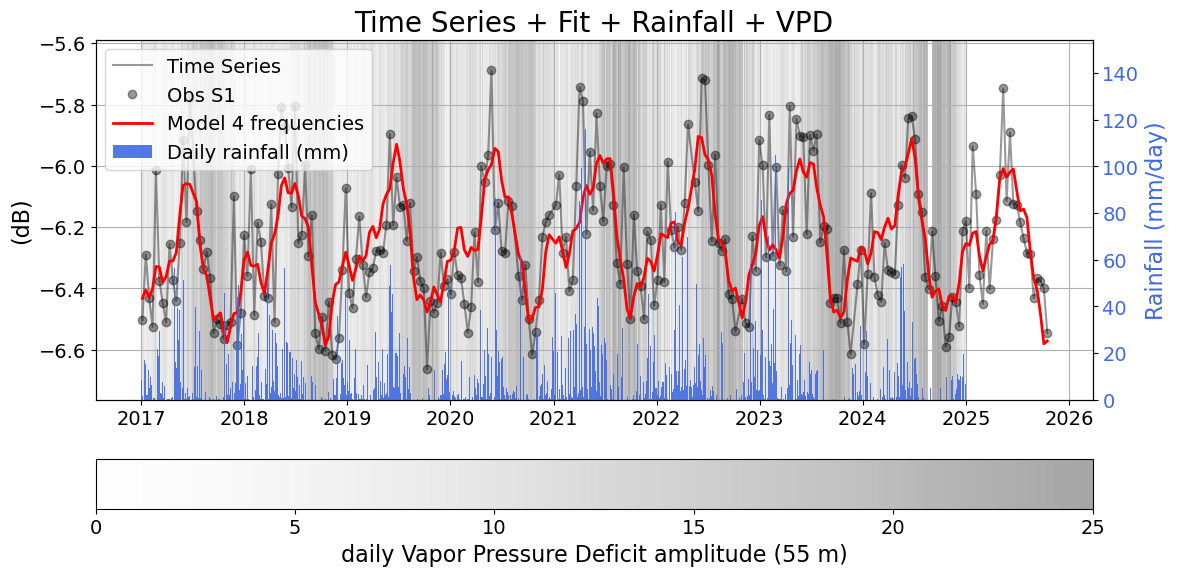

sigma= [2.74153371e-02 3.96267535e-05 1.19531972e-08 2.07789818e-02
 1.93533028e-02 7.39610823e-05 2.48401677e-02 1.37191884e-02
 1.31195215e-04 2.50199964e-02 1.38675984e-02 2.95718095e-04
 1.61332846e-02 2.32539692e-02 4.07560536e-04]
fitted_par= [np.float64(-6.367300315063483), np.float64(0.00015266398639522498), np.float64(-3.875190621460353e-08), np.float64(0.12328080759839033), np.float64(-0.13726784542552026), np.float64(-0.02477863867865823), np.float64(0.10196391490099505), np.float64(-0.011915749381725294), np.float64(-0.04526278125719392), np.float64(0.02978248607239536), np.float64(0.015244410035222594)]

=== Paramètres ajustés pour le signal VV_intact===
a (ordonnée à l'origine)       = -6.3673 ± 0.0274
b (tendance)     = 0.0002 ± 0.0000

c (terme quadratique) = -0.0000 ± 0.0000

end= 4.0
--- Fréquence 1 ---
A1 (sin)       = 0.1233 ± 0.0208
B1 (cos)       = -0.1373 ± 0.0194
Amplitude 1 = 0.1845 ± 0.0200
w1 (fréquence) = 0.0173 ± 0.0001

--- Fréquence 2 ---
A2 (sin)       =

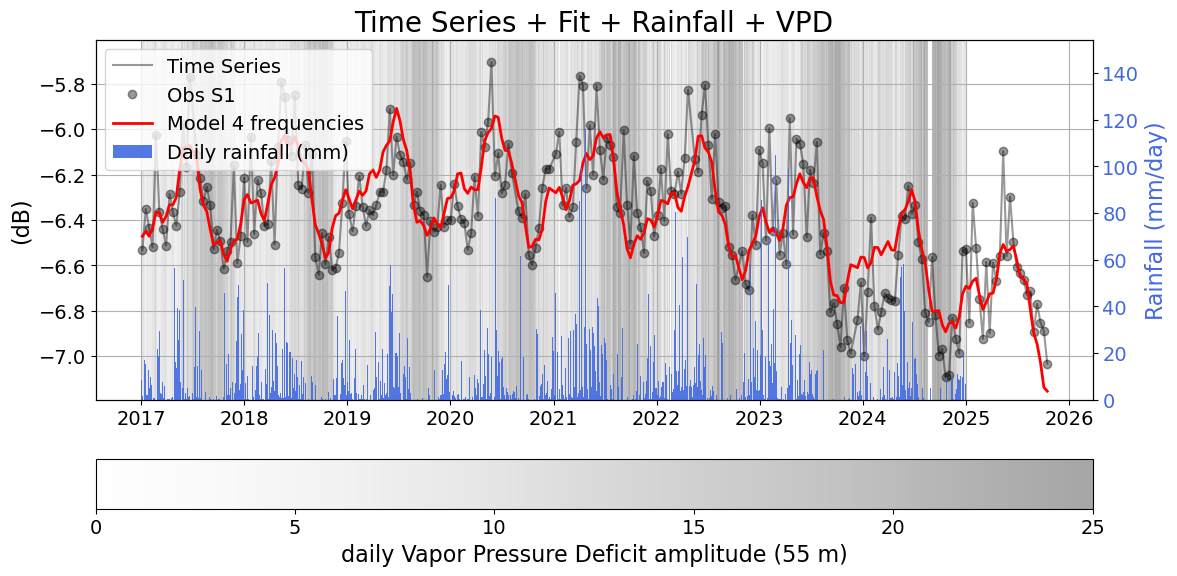

sigma= [3.13124057e-02 4.52573490e-05 1.36515211e-08 2.38659842e-02
 2.19542125e-02 8.19823646e-05 2.84262059e-02 1.55813822e-02
 1.49789788e-04 2.83950125e-02 1.61422034e-02 3.60600469e-04
 2.01957649e-02 2.52309965e-02 4.76762589e-04]
fitted_par= [np.float64(-6.407676189507704), np.float64(0.00031092811195266456), np.float64(-1.3944013071705704e-07), np.float64(0.12542475957792887), np.float64(-0.14267289897400715), np.float64(-0.02393061314046364), np.float64(0.1023127572651195), np.float64(-0.012366739725458905), np.float64(-0.04201742836665817), np.float64(0.02699633715842483), np.float64(0.018455135597938897)]

=== Paramètres ajustés pour le signal VV_defol modèle quadratique===
a (ordonnée à l'origine)       = -6.4077 ± 0.0313
b (tendance)     = 0.0003 ± 0.0000

c (terme quadratique) = -0.0000 ± 0.0000

end= 4.0
--- Fréquence 1 ---
A1 (sin)       = 0.1254 ± 0.0239
B1 (cos)       = -0.1427 ± 0.0220
Amplitude 1 = 0.1900 ± 0.0228
w1 (fréquence) = 0.0173 ± 0.0001

--- Fréquence 2 --

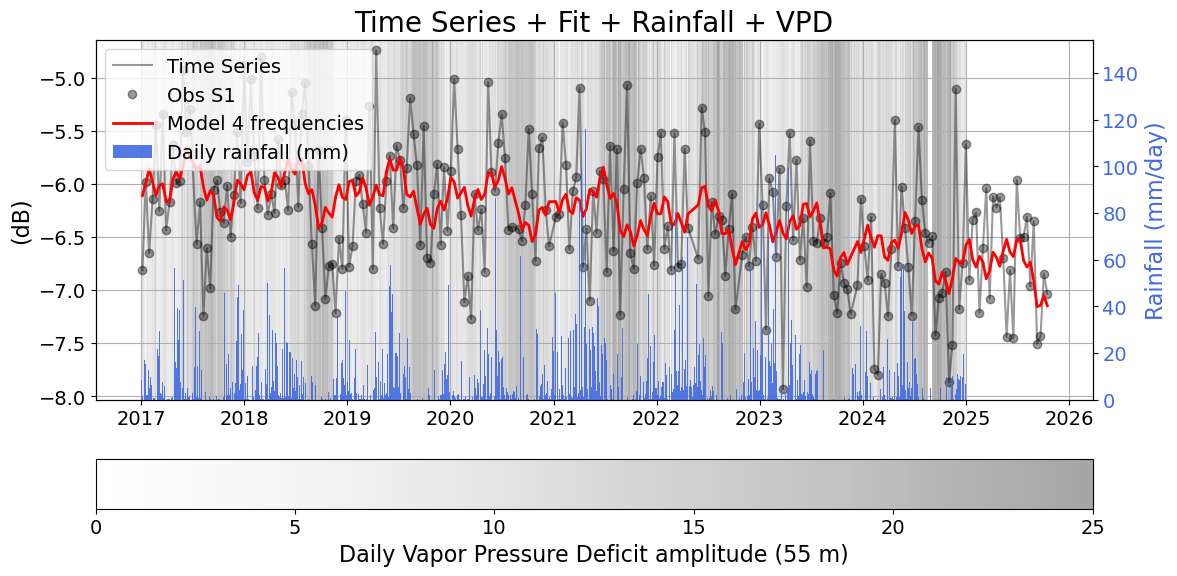

sigma= [1.02172149e-01 1.47596147e-04 4.44846928e-08 4.82791897e-02
 4.88075883e-02 4.87130956e-02 4.82278379e-02 4.88387364e-02
 4.80403130e-02 4.81318685e-02 4.86563609e-02]
fitted_par= [np.float64(-6.407676189507704), np.float64(0.00031092811195266456), np.float64(-1.3944013071705704e-07), np.float64(0.12542475957792887), np.float64(-0.14267289897400715), np.float64(-0.02393061314046364), np.float64(0.1023127572651195), np.float64(-0.012366739725458905), np.float64(-0.04201742836665817), np.float64(0.02699633715842483), np.float64(0.018455135597938897)]

=== Paramètres ajustés pour le signal defol_1ha quadratique===
a (ordonnée à l'origine)       = -6.4077 ± 0.1022
b (tendance)     = 0.0003 ± 0.0001

c (terme quadratique) = -0.0000 ± 0.0000

end= 4.0
--- Fréquence 1 ---
A1 (sin)       = 0.1254 ± 0.0483
B1 (cos)       = -0.1427 ± 0.0488
Amplitude 1 = 0.1900 ± 0.0486
--- Fréquence 2 ---
A2 (sin)       = -0.0239 ± 0.0487
B2 (cos)       = 0.1023 ± 0.0482
Amplitude 2 = 0.1051 ± 0.0483
--

0

In [ ]:
# fit sur toutes les ROIs
w_intact,sigma,fitted_params_intact,all_parameters_intact = fit_curve_n_freq(df_intact_VV_allROI,df_gx_daily, omega_4freq,nom="intact_allROI", n_freq=4, quad=True)
affichage_incertitudes(fitted_params_intact,sigma,w_intact,"VV_intact", quad=True)

w_defol,sigma,fitted_params_defol,all_parameters_defol = fit_curve_n_freq(df_defol_VV_allROI,df_gx_daily, omega_4freq,nom="defol_allROI",n_freq=4, quad=True)
affichage_incertitudes(fitted_params_defol,sigma,w_defol,"VV_defol modèle quadratique", quad=True)

sigma_fixed,params_defol_1ha = fit_curve_n_freq_fixed(df_defol_VV_ROI,df_gx_daily, w_defol, fitted_params_defol,nom="defol_1ha", quad=True)
affichage_incertitudes(fitted_params_defol,sigma_fixed,[],"defol_1ha quadratique", quad=True)